# Initialization

## Import

In [2]:
import matplotlib.pyplot as plt
import params_searchers.feature_importance_extractor as feat_imp_ext
import lgbm_optuna_column_filter as lgbm_fl
import pandas as pd
from sklearn.model_selection import TimeSeriesSplit
import params_searchers.ts_splitter as ts_splitter
import warnings
warnings.filterwarnings('ignore')

## Constants

In [3]:
METRIC = 'rmse'
OBJECTIVE = 'regression'
OPTIMIZATION_DIRECTION = 'minimize'
CATEGORIES = [[], ['season'], ['month'], ['year'], ['season', 'month'], ['season', 'month', 'year'], ['season', 'month', 'weekday']]

TRAIN_DATE_FROM = '2015-01-08'
TRAIN_DATE_TO = '2023-02-05'
VAL_DATE_FROM = '2023-02-06'
VAL_DATE_TO = '2023-02-12'

CSV_JOINT_FILE = '../../datasources/ds_joint/ds.csv'
CSV_SCORE_FILE = '../../datasources/pm25_scores/score.csv'

## Source data load

In [4]:
df_joint = pd.read_csv(CSV_JOINT_FILE, parse_dates=True, index_col='DatetimeEnd')

In [4]:
df_score = pd.DataFrame(columns=['train_score', 'val_score', 'target', 'pol_id', 'weather_YN', 'AQI_lags_YN', 'C_lags_YN', 'simple_lags_YN', 'gen_lags_YN', 'params', 'categories', 'top_feat_count'])

## Functions

In [ ]:
def score_by_feature_count(o_helper, len_features, best_params, categories):
    tr_by_cat = []
    vl_by_cat = []
    o_helper.study_best_params = best_params
    for cat in categories:
        train_scs = []
        val_scs = []
        for i in range(1, len_features):
            o_helper.set_best_features_by_count(i)
            score_tr, score_vl, mdl = o_helper.run_model_and_eval(params=best_params,  categorical_features=cat, best_features_only=True, set_as_best_model=False)
            train_scs.append(score_tr)
            val_scs.append(score_vl)
        tr_by_cat.append(train_scs)
        vl_by_cat.append(val_scs)
    return tr_by_cat, vl_by_cat


def plot_score_grouped_by_categories_by_feature_count(len_features, score_by_cat, sub_title=""):
    plt.figure(figsize=(21, 7))
    for i in range(0, len(categories)):
        plt.plot(range(1, len_features),score_by_cat[i], label=("_".join(categories[i]) if len(categories[i]) > 0 else "no_cat"))
    plt.title(f'Score by features count. {sub_title}')
    plt.legend()
    plt.show()


def plot_train_val_score_by_feature_count(len_features, train_scs, val_scs, sub_title=""):
    plt.figure(figsize=(21, 7))
    plt.plot(range(1, len_features),train_scs, label="train_score")
    plt.plot(range(1, len_features),val_scs, label="val_score")
    plt.title(f'Train/Val score by features count. {sub_title}')
    plt.legend()
    plt.show()


def score_and_plot_by_feature_count(o_helper, len_features, best_params, categories):
    tr_by_cat, vl_by_cat = score_by_feature_count(o_helper, len_features, best_params, categories)
    plot_score_grouped_by_categories_by_feature_count(len_features, tr_by_cat, sub_title="Train scores")
    plot_score_grouped_by_categories_by_feature_count(len_features, vl_by_cat, sub_title="Val scores")
    for i in range(len(categories)):
        plot_train_val_score_by_feature_count(len_features, tr_by_cat[i], vl_by_cat[i],
                                              sub_title=f"First cats: {('_'.join(categories[i]) if len(categories[i]) > 0 else 'no_cat')}")


def init_optuna_helper(df, pol_id, default_category, categories, use_aqi_cols=False, use_c_mean_cols=True, use_lag_cols=True, use_gen_lags_cols=True, use_weather_cols=True):
    default_params = {'n_jobs': -1, 'verbosity': -1, 'metric': METRIC, 'boosting_type': 'gbdt',
    'extra_trees': True, 'n_estimators': 1000, 'num_leaves': 150, 'learning_rate': 0.01, 'subsample': 0.7, 'subsample_freq': 5, 'subsample_for_bin': 100000, 'min_child_samples': 30, 'reg_alpha': 0.1, 'reg_lambda': 0.2, 'max_depth': 10, 'max_bin': 150}
    o_helper, x_tr, y_tr, x_vl, y_vl = lgbm_fl.init_optuna(
        df=df, pol_id=pol_id, prediction_value_type=lgbm_fl.PredictionValueType.AQI,
        use_aqi_cols=use_aqi_cols, use_c_mean_cols=use_c_mean_cols, use_lag_cols=use_lag_cols, use_gen_lags_cols=use_gen_lags_cols, use_weather_cols=use_weather_cols,
        train_start_dt=TRAIN_DATE_FROM, train_end_dt=TRAIN_DATE_TO, test_start_dt=VAL_DATE_FROM, test_end_dt=VAL_DATE_TO, default_params=default_params, default_category=default_category, categories_for_optimization=categories, default_top_features_count=-1)
    return o_helper, x_tr, y_tr, x_vl, y_vl


def run_test(df, pol_id, default_category, categories, use_aqi_cols=False, use_c_mean_cols=True, use_lag_cols=True, use_gen_lags_cols=True, use_weather_cols=True):

    o_helper, x_tr, y_tr, x_vl, y_vl = init_optuna_helper(df, pol_id, default_category, categories, use_aqi_cols, use_c_mean_cols, use_lag_cols,use_gen_lags_cols, use_weather_cols)

    o_helper.run_params_search(n_trials=100, n_jobs=6, study_name="_", save_best_params=True,   direction=OPTIMIZATION_DIRECTION, best_features_only=True, search_category=True, with_pruner=True, cv_splitter= TimeSeriesSplit(16), warm_params=None)

    best_params = o_helper.study_best_params
    best_categories =  o_helper.study_best_params['categorical_features']
    best_features_count = len(x_tr.columns)

    score_train, score_val, _ = o_helper.run_model_and_eval(params=best_params,  categorical_features=best_categories, best_features_only=True, set_as_best_model=True)

    feat_imp_df = feat_imp_ext.plot_feature_importance(o_helper.best_model, o_helper.best_features_list, num=30, plot_bar=True)
    return o_helper, score_train, score_val, best_params, best_categories, best_features_count, feat_imp_df


def run_model_by_feature_count(o_helper, best_params, best_categories, best_features_count):
    o_helper.study_best_params = best_params
    o_helper.set_best_features_by_count(best_features_count)
    score_tr, score_vl, _ = o_helper.run_model_and_eval(params=best_params,  categorical_features=best_categories, best_features_only=True, set_as_best_model=True)
    return score_tr, score_vl


def save_score_and_params(target, pol_id, use_weather_cols, use_aqi_cols, use_c_mean_cols, use_lag_cols, use_gen_lags_cols,
                          best_params, best_categories, best_features_count, score_train, score_val):
    df_score.loc[df_score.shape[0]] = {'target': target, 'pol_id' : pol_id, 'weather_YN': use_weather_cols, 'AQI_lags_YN': use_aqi_cols,
                                       'C_lags_YN': use_c_mean_cols, 'simple_lags_YN': use_lag_cols, 'gen_lags_YN': use_gen_lags_cols,
                                       'params': best_params, 'categories': best_categories, 'top_feat_count': best_features_count,
                                       'train_score': score_train, 'val_score': score_val }
    df_score.to_csv(CSV_SCORE_FILE)

# Test models

## PM 2.5

### PM2.5 - AQI weather, lags, gen lags

In [46]:
pol_id = 6001
categories=[['month', 'weekday'], ['season', 'month'], ['season', 'month', 'weekday']]
default_category=['month', 'weekday']
use_aqi_cols = False
use_c_mean_cols=True
use_lag_cols = True
use_gen_lags_cols =True
use_weather_cols = True

[I 2023-03-01 17:25:15,826] A new study created in memory with name: _


run_params_search n_trials=10, search_category=True, best_features_only=True, with_pruner=True


  0%|          | 0/10 [00:00<?, ?it/s]

Trial 1 finished with best value: 36.43004321477383 and parameters: {'n_jobs': -1, 'verbosity': -1, 'objective': 'regression', 'metric': 'rmse', 'boosting_type': 'gbdt', 'extra_trees': False, 'n_estimators': 2400, 'num_leaves': 39, 'learning_rate': 0.13955479448311064, 'subsample': 0.47405375976335906, 'subsample_freq': 4, 'subsample_for_bin': 461365, 'min_child_samples': 473, 'reg_alpha': 0.8466914317107669, 'reg_lambda': 0.29512592129660564, 'max_depth': 5, 'max_bin': 396, 'categorical_features': ['season', 'month', 'weekday']}. 
Trial 3 finished with best value: 31.901224075324365 and parameters: {'n_jobs': -1, 'verbosity': -1, 'objective': 'regression', 'metric': 'rmse', 'boosting_type': 'gbdt', 'extra_trees': False, 'n_estimators': 2100, 'num_leaves': 63, 'learning_rate': 0.05546308942113839, 'subsample': 0.2846278865963082, 'subsample_freq': 3, 'subsample_for_bin': 180145, 'min_child_samples': 230, 'reg_alpha': 0.26551419148094246, 'reg_lambda': 0.8704299229637551, 'max_depth': 1

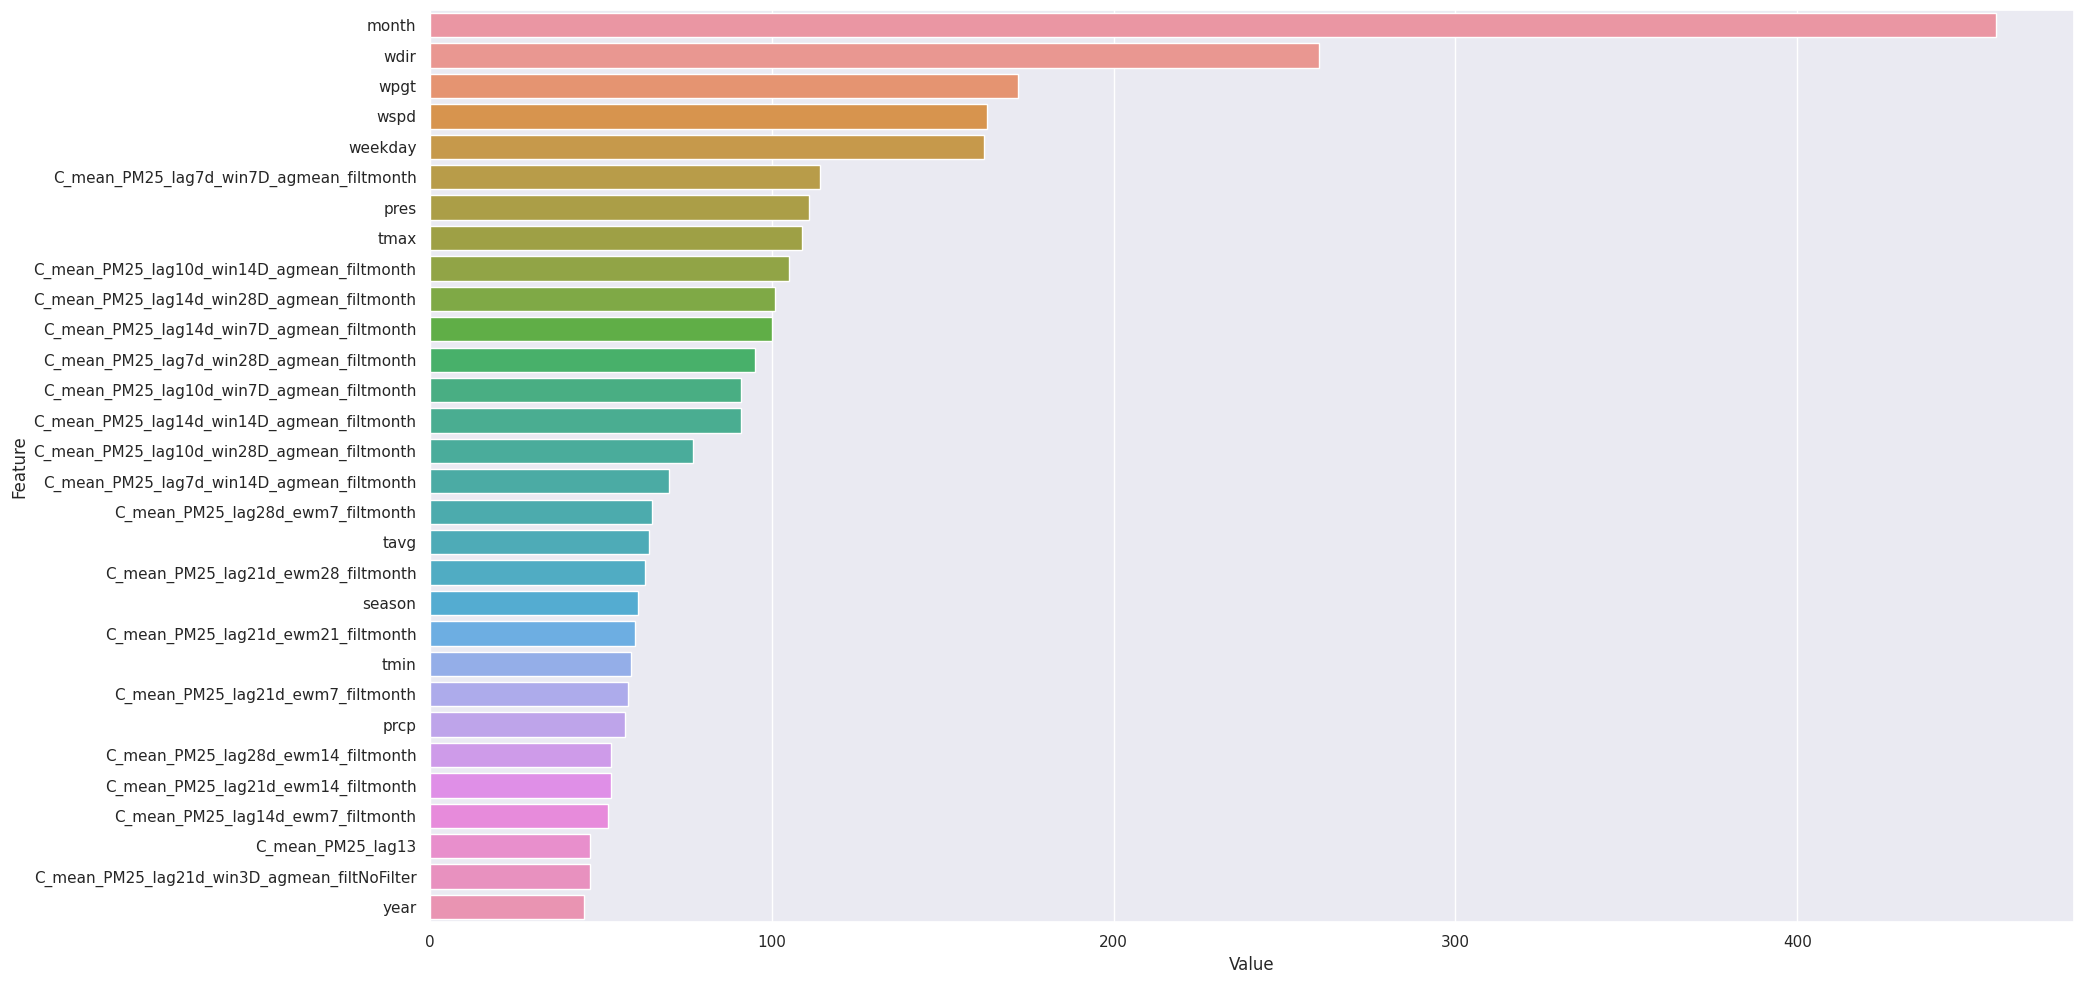

(8.311761500503348, 44.871087766894206)

In [13]:
o_helper, score_train, score_val, best_params, best_categories, best_features_count, feat_imp_df = \
    run_test(df_joint, pol_id, default_category=default_category, categories=categories,
             use_aqi_cols=use_aqi_cols, use_c_mean_cols=use_c_mean_cols, use_lag_cols=use_lag_cols, use_gen_lags_cols=use_gen_lags_cols, use_weather_cols=use_weather_cols)
score_train, score_val

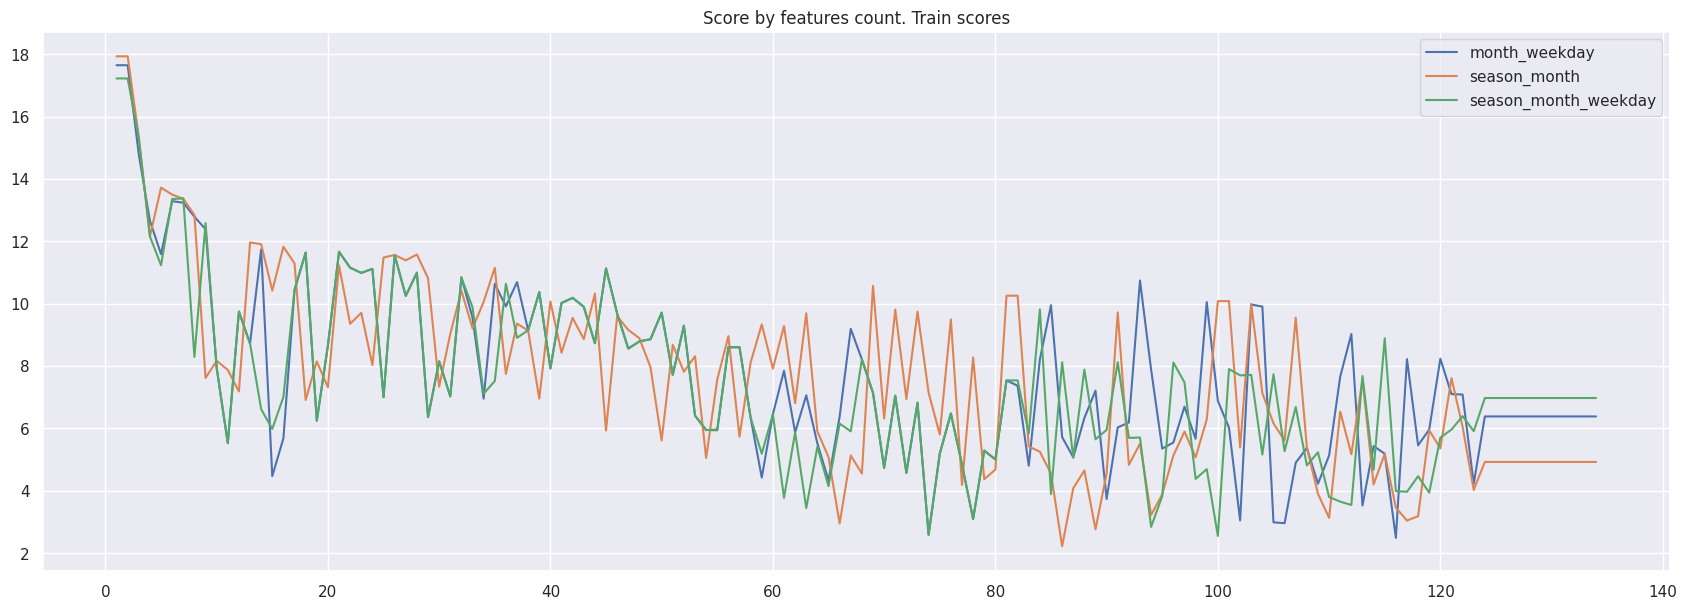

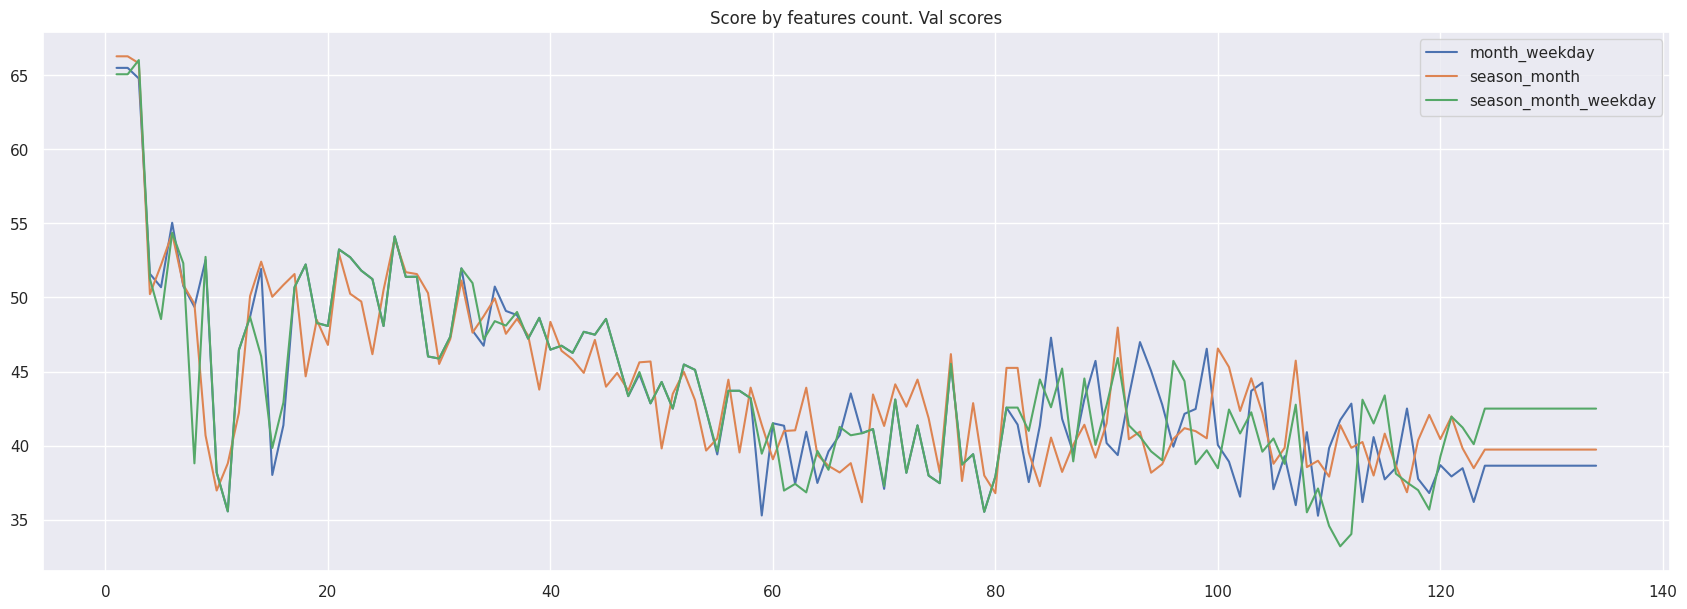

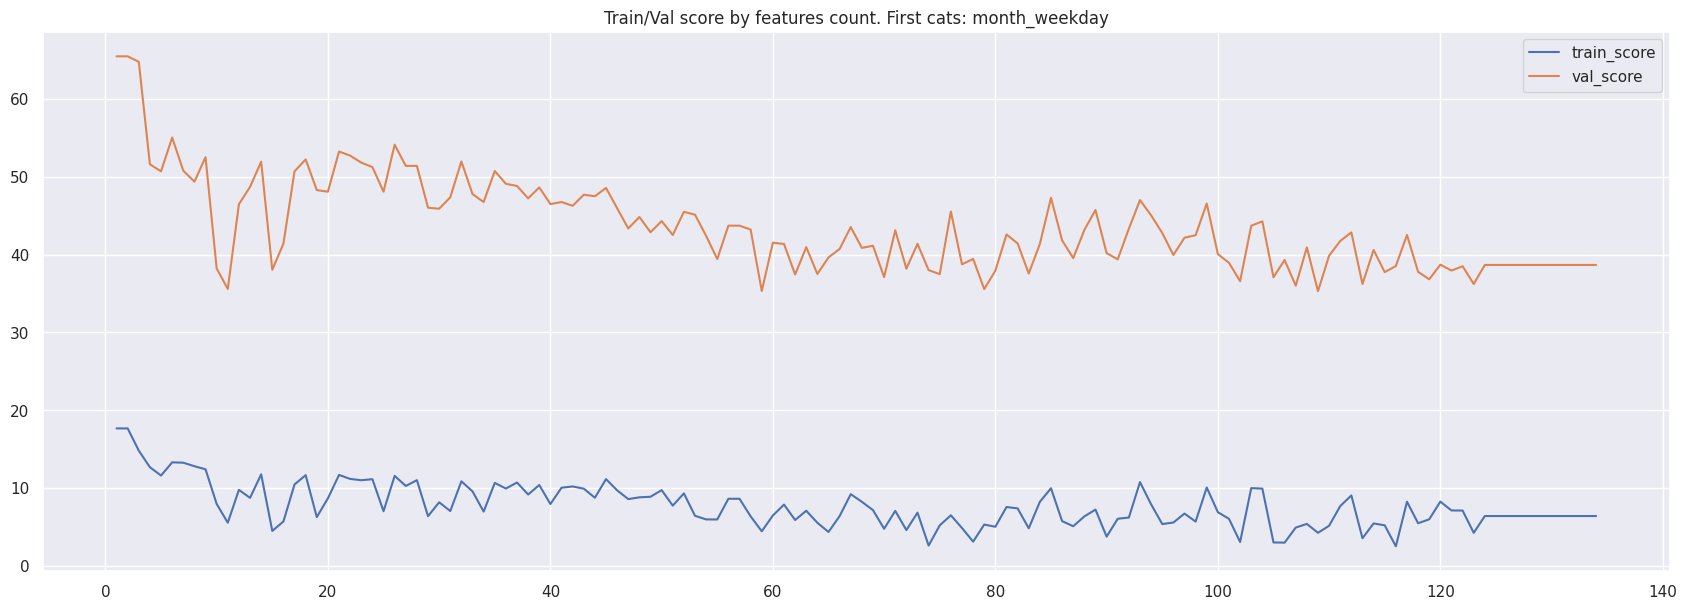

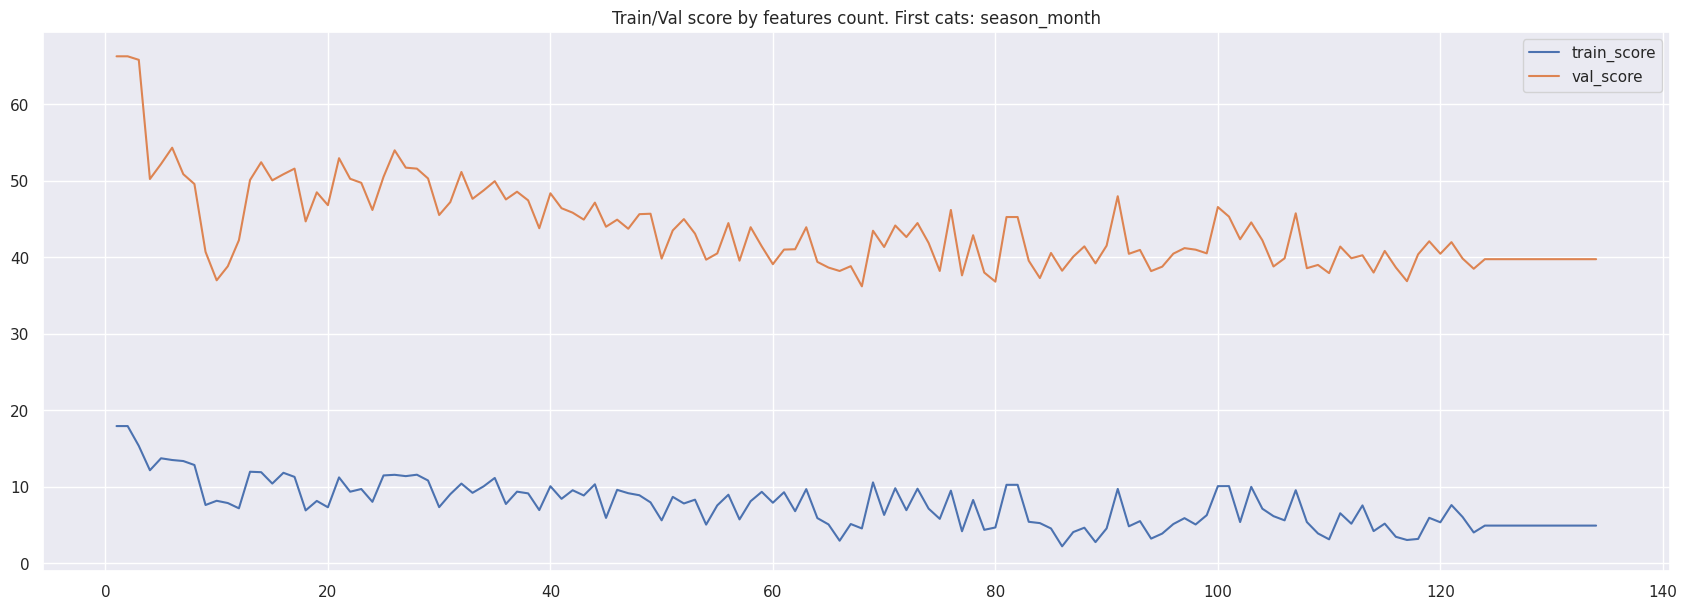

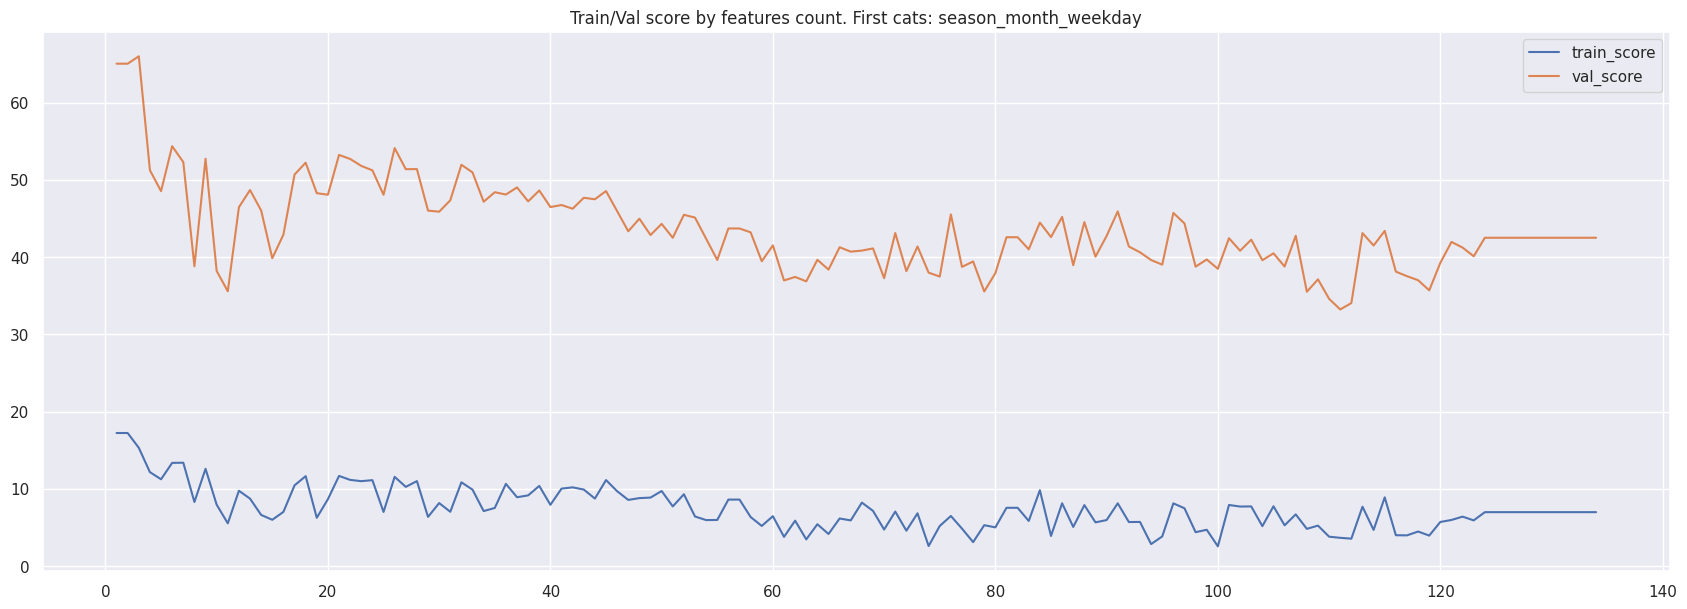

In [88]:
best_params = {'n_jobs': -1, 'verbosity': -1, 'objective': 'regression', 'metric': 'rmse', 'boosting_type': 'gbdt', 'extra_trees': False, 'n_estimators': 2100, 'num_leaves': 97, 'learning_rate': 0.11890042003021366, 'subsample': 0.4318782580934736, 'subsample_freq': 0, 'subsample_for_bin': 193295, 'min_child_samples': 14, 'reg_alpha': 0.394194026403052, 'reg_lambda': 0.708405421324422, 'max_depth': 3, 'max_bin': 206}

score_and_plot_by_feature_count(o_helper, len_features=min(best_features_count, 150), best_params=best_params, categories=categories)

In [47]:
best_params = {'n_jobs': -1, 'verbosity': -1, 'objective': 'regression', 'metric': 'rmse', 'boosting_type': 'gbdt', 'extra_trees': False, 'n_estimators': 2100, 'num_leaves': 97, 'learning_rate': 0.11890042003021366, 'subsample': 0.4318782580934736, 'subsample_freq': 0, 'subsample_for_bin': 193295, 'min_child_samples': 14, 'reg_alpha': 0.394194026403052, 'reg_lambda': 0.708405421324422, 'max_depth': 3, 'max_bin': 206}
best_categories = ['month', 'weekday']
best_features_count = 70

o_helper, _, _, _, _ = init_optuna_helper(df_joint, pol_id, default_category=best_categories, categories=[],
             use_aqi_cols=use_aqi_cols, use_c_mean_cols=use_c_mean_cols, use_lag_cols=use_lag_cols, use_gen_lags_cols=use_gen_lags_cols,
                                          use_weather_cols=use_weather_cols)

score_train, score_val = run_model_by_feature_count(o_helper, best_params, best_categories=best_categories, best_features_count=best_features_count)
score_train, score_val

(4.741127620346672, 37.0975794319391)

In [48]:
save_score_and_params(target='AQI', pol_id=pol_id, use_weather_cols=use_weather_cols, use_aqi_cols=use_aqi_cols, use_c_mean_cols=use_c_mean_cols,
                      use_lag_cols=use_lag_cols, use_gen_lags_cols=use_gen_lags_cols, best_params=best_params, best_categories=best_categories,
                      best_features_count=best_features_count, score_train=score_train, score_val=score_val)

### PM2.5 - AQI lags, gen lags

In [49]:
pol_id = 6001
categories=[['month', 'weekday'], ['season', 'month'], ['season', 'month', 'weekday']]
default_category=['month', 'weekday']
use_aqi_cols = False
use_c_mean_cols=True
use_lag_cols = True
use_gen_lags_cols =True
use_weather_cols = False

run_params_search n_trials=100, search_category=True, best_features_only=True, with_pruner=True


  0%|          | 0/100 [00:00<?, ?it/s]

Trial 2 finished with best value: 30.0284626851883 and parameters: {'n_jobs': -1, 'verbosity': -1, 'objective': 'regression', 'metric': 'rmse', 'boosting_type': 'gbdt', 'extra_trees': False, 'n_estimators': 1900, 'num_leaves': 72, 'learning_rate': 0.09912091766563294, 'subsample': 0.09280121443065237, 'subsample_freq': 0, 'subsample_for_bin': 122763, 'min_child_samples': 552, 'reg_alpha': 0.24782428240975052, 'reg_lambda': 0.2871058524594158, 'max_depth': 5, 'max_bin': 83, 'categorical_features': ['season', 'month', 'weekday']}. 
Trial 5 finished with best value: 29.992788198365346 and parameters: {'n_jobs': -1, 'verbosity': -1, 'objective': 'regression', 'metric': 'rmse', 'boosting_type': 'gbdt', 'extra_trees': True, 'n_estimators': 2800, 'num_leaves': 90, 'learning_rate': 0.0787227499536775, 'subsample': 0.9196100698224192, 'subsample_freq': 5, 'subsample_for_bin': 230779, 'min_child_samples': 502, 'reg_alpha': 0.7029881164384739, 'reg_lambda': 0.9103496714991111, 'max_depth': 5, 'ma

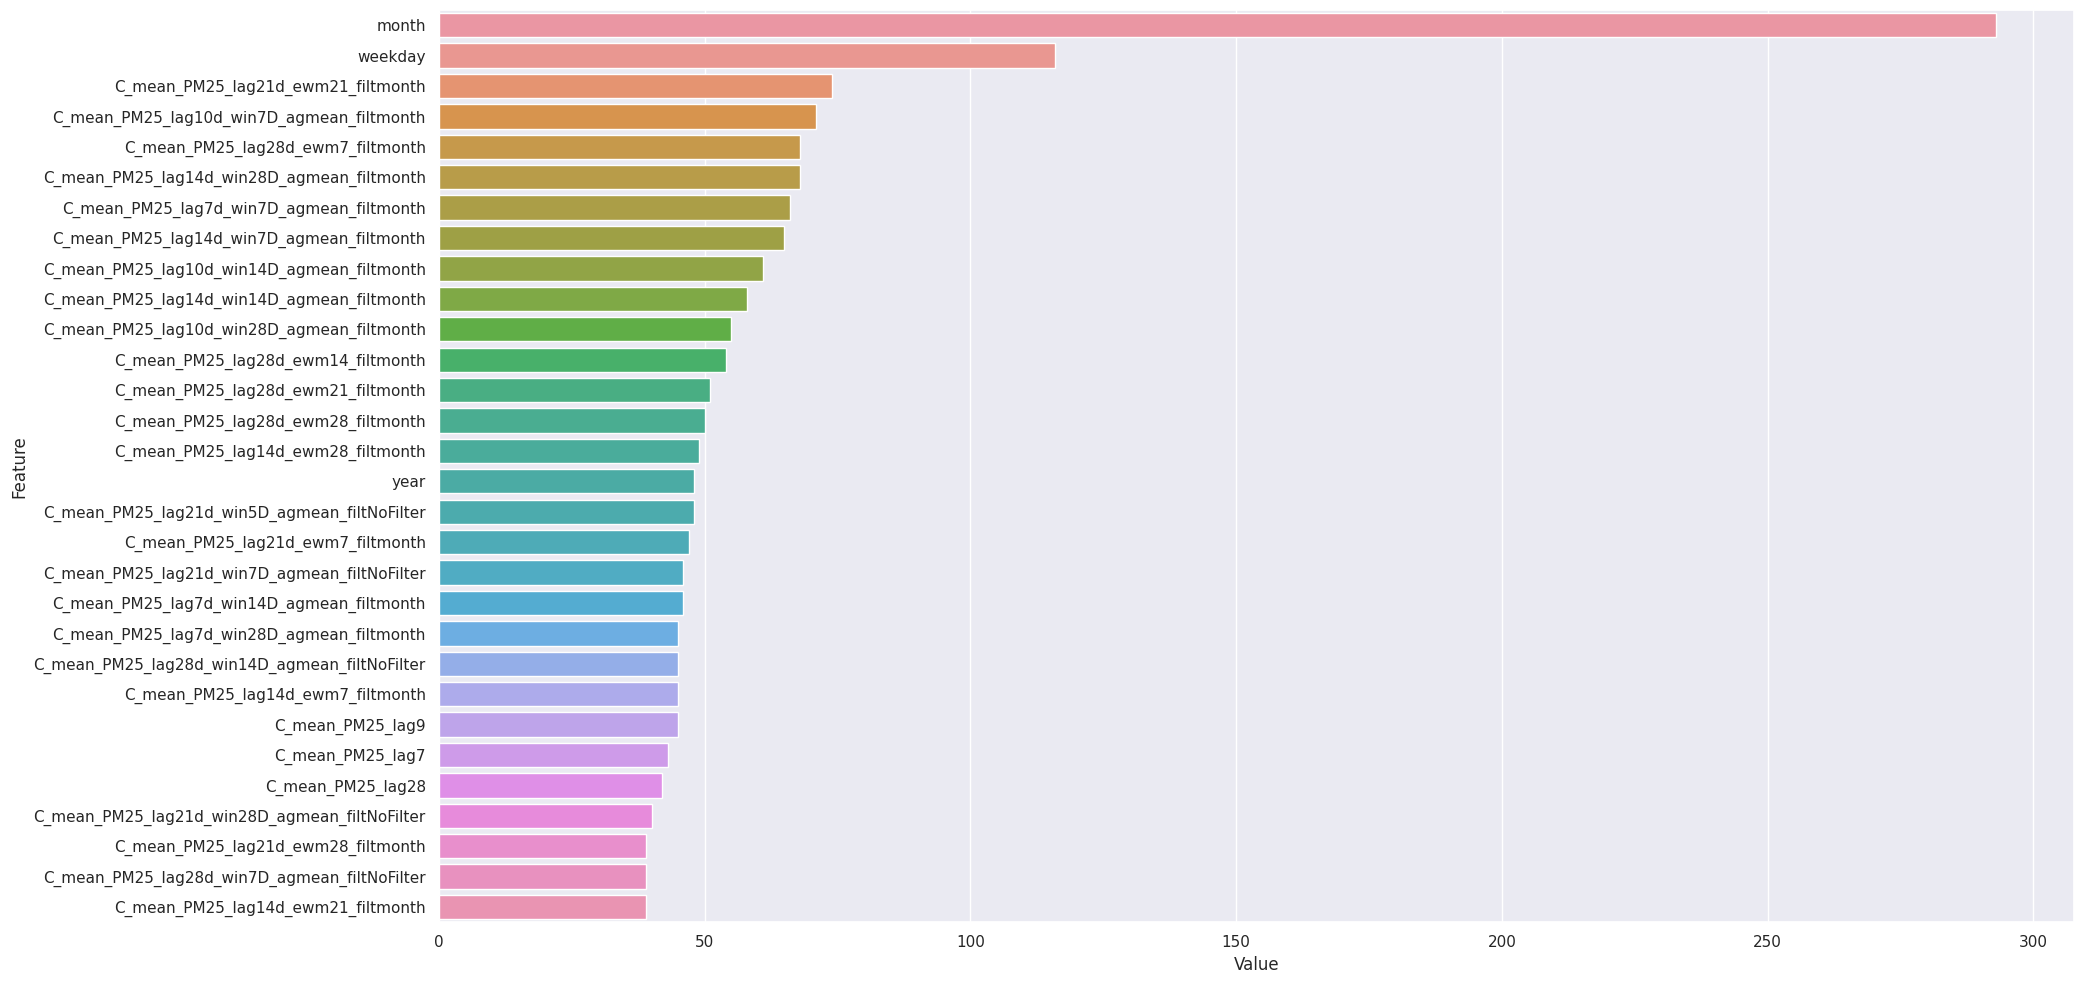

(9.171279966153719, 64.22873357788919)

In [50]:
o_helper, score_train, score_val, best_params, best_categories, best_features_count, feat_imp_df = \
    run_test(df_joint, pol_id, default_category=default_category, categories=categories,
             use_aqi_cols=use_aqi_cols, use_c_mean_cols=use_c_mean_cols, use_lag_cols=use_lag_cols, use_gen_lags_cols=use_gen_lags_cols, use_weather_cols=use_weather_cols)
score_train, score_val

In [58]:
best_params = {'n_jobs': -1, 'verbosity': -1, 'objective': 'regression', 'metric': 'rmse', 'boosting_type': 'gbdt', 'extra_trees': True, 'n_estimators': 2900, 'num_leaves': 66, 'learning_rate': 0.12773019092749138, 'subsample': 0.7831659496800467, 'subsample_freq': 8, 'subsample_for_bin': 391616, 'min_child_samples': 73, 'reg_alpha': 0.6968311953663399, 'reg_lambda': 0.32426383763516786, 'max_depth': 5, 'max_bin': 329}
best_categories = ['month', 'weekday']
best_features_count = 70

score_train, score_val = run_model_by_feature_count(o_helper, best_params, best_categories=best_categories, best_features_count=best_features_count)
score_train, score_val

(11.56874910200041, 66.33392921297678)

In [59]:
save_score_and_params(target='AQI', pol_id=pol_id, use_weather_cols=use_weather_cols, use_aqi_cols=use_aqi_cols, use_c_mean_cols=use_c_mean_cols,
                      use_lag_cols=use_lag_cols, use_gen_lags_cols=use_gen_lags_cols, best_params=best_params, best_categories=best_categories,
                      best_features_count=best_features_count, score_train=score_train, score_val=score_val)

### PM2.5 - AQI weather, lags

In [60]:
pol_id = 6001
categories=[['month', 'weekday'], ['season', 'month'], ['season', 'month', 'weekday']]
default_category=['month', 'weekday']
use_aqi_cols = False
use_c_mean_cols=True
use_lag_cols = True
use_gen_lags_cols =False
use_weather_cols = True

run_params_search n_trials=100, search_category=True, best_features_only=True, with_pruner=True


  0%|          | 0/100 [00:00<?, ?it/s]

Trial 4 finished with best value: 47.65738808816404 and parameters: {'n_jobs': -1, 'verbosity': -1, 'objective': 'regression', 'metric': 'rmse', 'boosting_type': 'gbdt', 'extra_trees': True, 'n_estimators': 1700, 'num_leaves': 84, 'learning_rate': 0.09355263273755747, 'subsample': 0.202164769665658, 'subsample_freq': 4, 'subsample_for_bin': 289043, 'min_child_samples': 427, 'reg_alpha': 0.5637945894541702, 'reg_lambda': 0.8363693940814599, 'max_depth': 9, 'max_bin': 243, 'categorical_features': ['season', 'month', 'weekday']}. 
Trial 3 finished with best value: 30.444463337798997 and parameters: {'n_jobs': -1, 'verbosity': -1, 'objective': 'regression', 'metric': 'rmse', 'boosting_type': 'gbdt', 'extra_trees': False, 'n_estimators': 1800, 'num_leaves': 123, 'learning_rate': 0.14944281331311549, 'subsample': 0.23931302846371838, 'subsample_freq': 8, 'subsample_for_bin': 168783, 'min_child_samples': 172, 'reg_alpha': 0.8938962304815726, 'reg_lambda': 0.2636477251306174, 'max_depth': 7, '

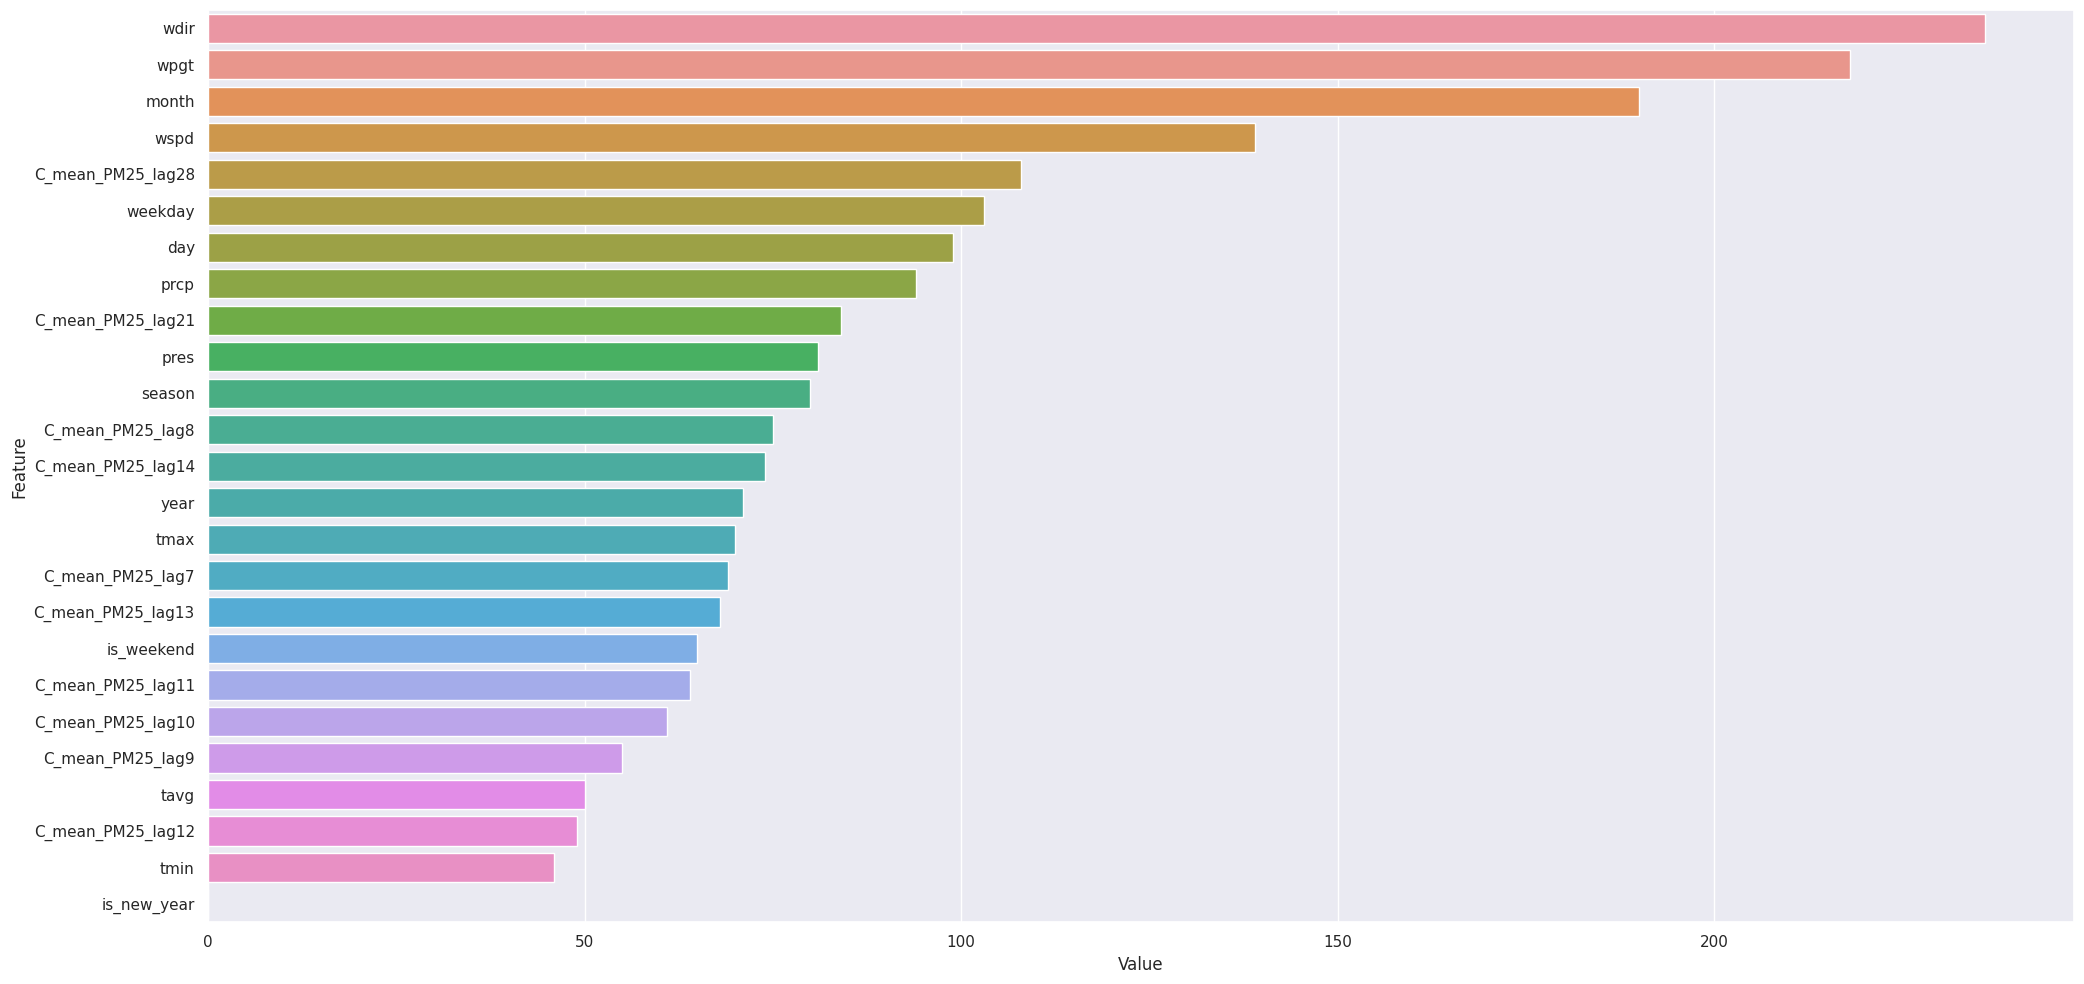

(10.197384104641882, 48.318526711830934)

In [35]:
o_helper, score_train, score_val, best_params, best_categories, best_features_count, feat_imp_df = \
    run_test(df_joint, pol_id, default_category=default_category, categories=categories,
             use_aqi_cols=use_aqi_cols, use_c_mean_cols=use_c_mean_cols, use_lag_cols=use_lag_cols, use_gen_lags_cols=use_gen_lags_cols, use_weather_cols=use_weather_cols)
score_train, score_val

In [ ]:
#score_and_plot_by_feature_count(o_helper, len_features=min(best_features_count, 150), best_params=best_params, categories=categories)

In [43]:
best_categories = ['month', 'weekday']
best_features_count = 70

score_train, score_val = run_model_by_feature_count(o_helper, best_params, best_categories=best_categories, best_features_count=best_features_count)
score_train, score_val

(8.55951491370446, 46.97933900468251)

In [44]:
save_score_and_params(target='AQI', pol_id=pol_id, use_weather_cols=use_weather_cols, use_aqi_cols=use_aqi_cols, use_c_mean_cols=use_c_mean_cols,
                      use_lag_cols=use_lag_cols, use_gen_lags_cols=use_gen_lags_cols, best_params=best_params, best_categories=best_categories,
                      best_features_count=best_features_count, score_train=score_train, score_val=score_val)

### PM2.5 - AQI weather, gen lags

In [63]:
pol_id = 6001
categories=[['month', 'weekday'], ['season', 'month'], ['season', 'month', 'weekday']]
default_category=['month', 'weekday']
use_aqi_cols = False
use_c_mean_cols=True
use_lag_cols = False
use_gen_lags_cols =True
use_weather_cols = True

run_params_search n_trials=100, search_category=True, best_features_only=True, with_pruner=True


  0%|          | 0/100 [00:00<?, ?it/s]

Trial 2 finished with best value: 24.187729161588074 and parameters: {'n_jobs': -1, 'verbosity': -1, 'objective': 'regression', 'metric': 'rmse', 'boosting_type': 'gbdt', 'extra_trees': True, 'n_estimators': 1400, 'num_leaves': 119, 'learning_rate': 0.14699113957716364, 'subsample': 0.7063660655618115, 'subsample_freq': 1, 'subsample_for_bin': 319426, 'min_child_samples': 251, 'reg_alpha': 0.9114353405621362, 'reg_lambda': 0.2953735633668422, 'max_depth': 3, 'max_bin': 245, 'categorical_features': ['month', 'weekday']}. 
Trial 0 finished with best value: 19.850544958578567 and parameters: {'n_jobs': -1, 'verbosity': -1, 'objective': 'regression', 'metric': 'rmse', 'boosting_type': 'gbdt', 'extra_trees': True, 'n_estimators': 1900, 'num_leaves': 69, 'learning_rate': 0.14021310010804855, 'subsample': 0.657072708958782, 'subsample_freq': 4, 'subsample_for_bin': 453823, 'min_child_samples': 104, 'reg_alpha': 0.6735455441652652, 'reg_lambda': 0.20857661798419613, 'max_depth': 12, 'max_bin':

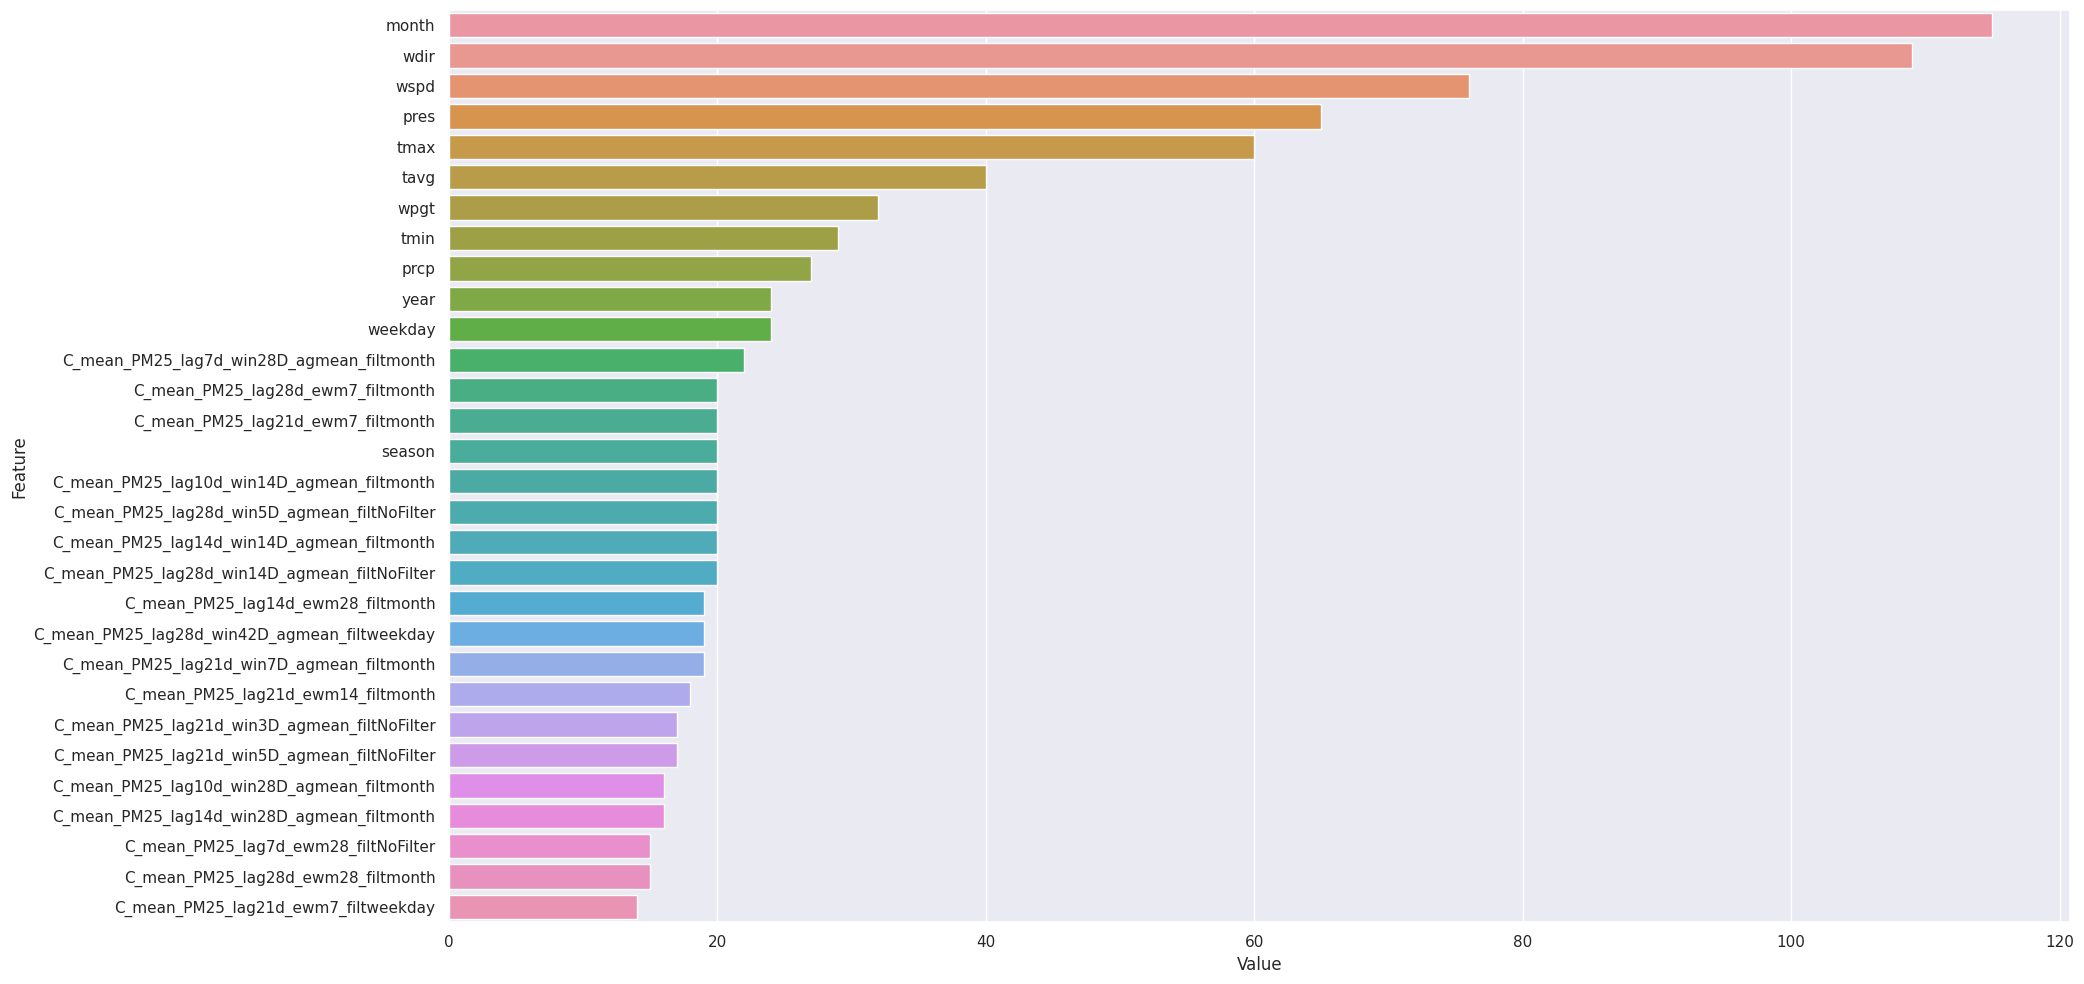

(10.19695169114189, 46.33802571421732)

In [90]:
o_helper, score_train, score_val, best_params, best_categories, best_features_count, feat_imp_df = \
    run_test(df_joint, pol_id, default_category=default_category, categories=categories,
             use_aqi_cols=use_aqi_cols, use_c_mean_cols=use_c_mean_cols, use_lag_cols=use_lag_cols, use_gen_lags_cols=use_gen_lags_cols, use_weather_cols=use_weather_cols)
score_train, score_val

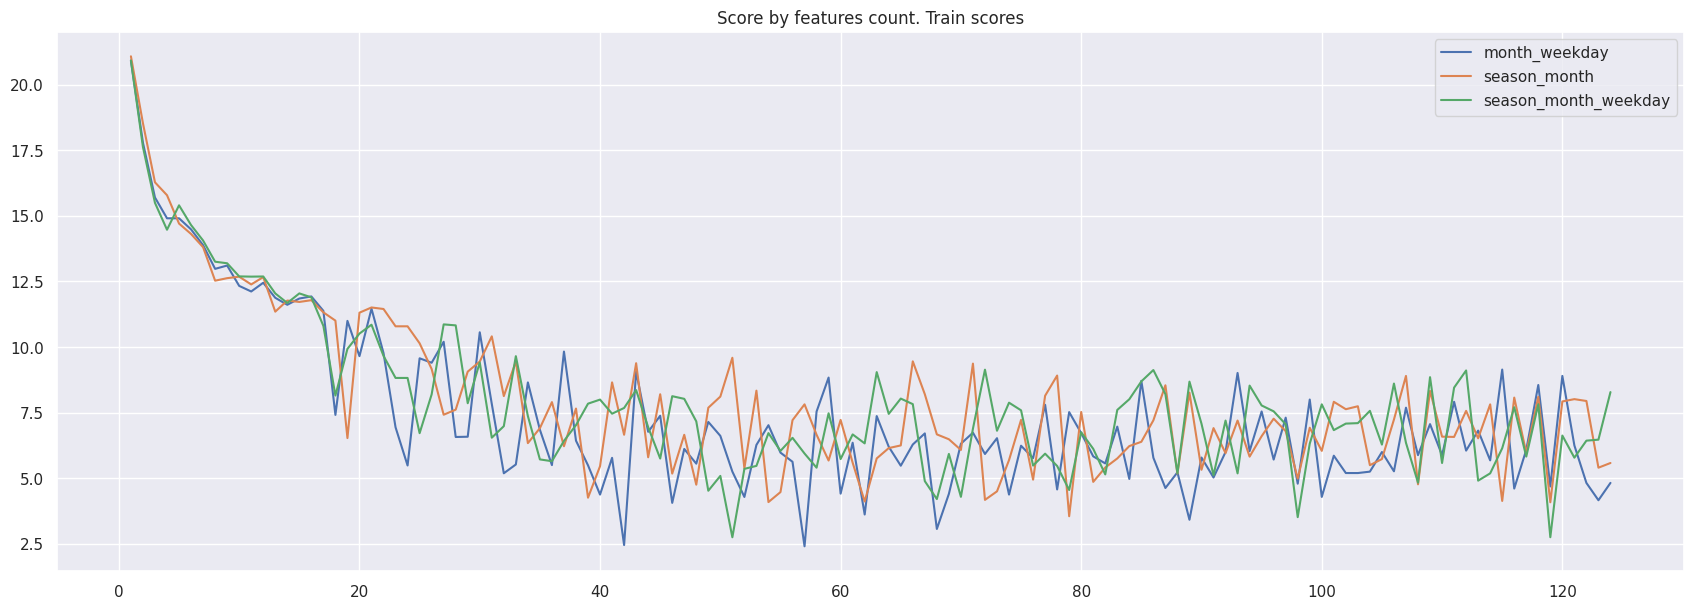

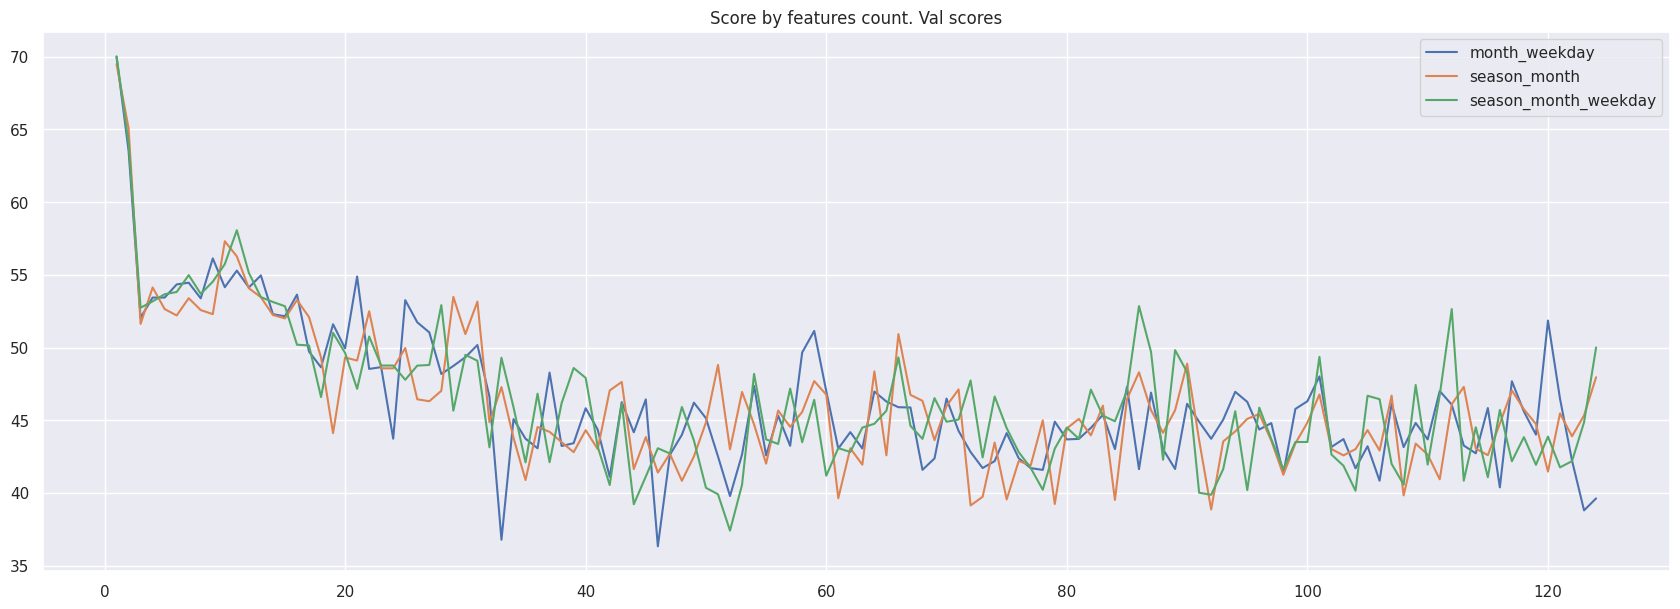

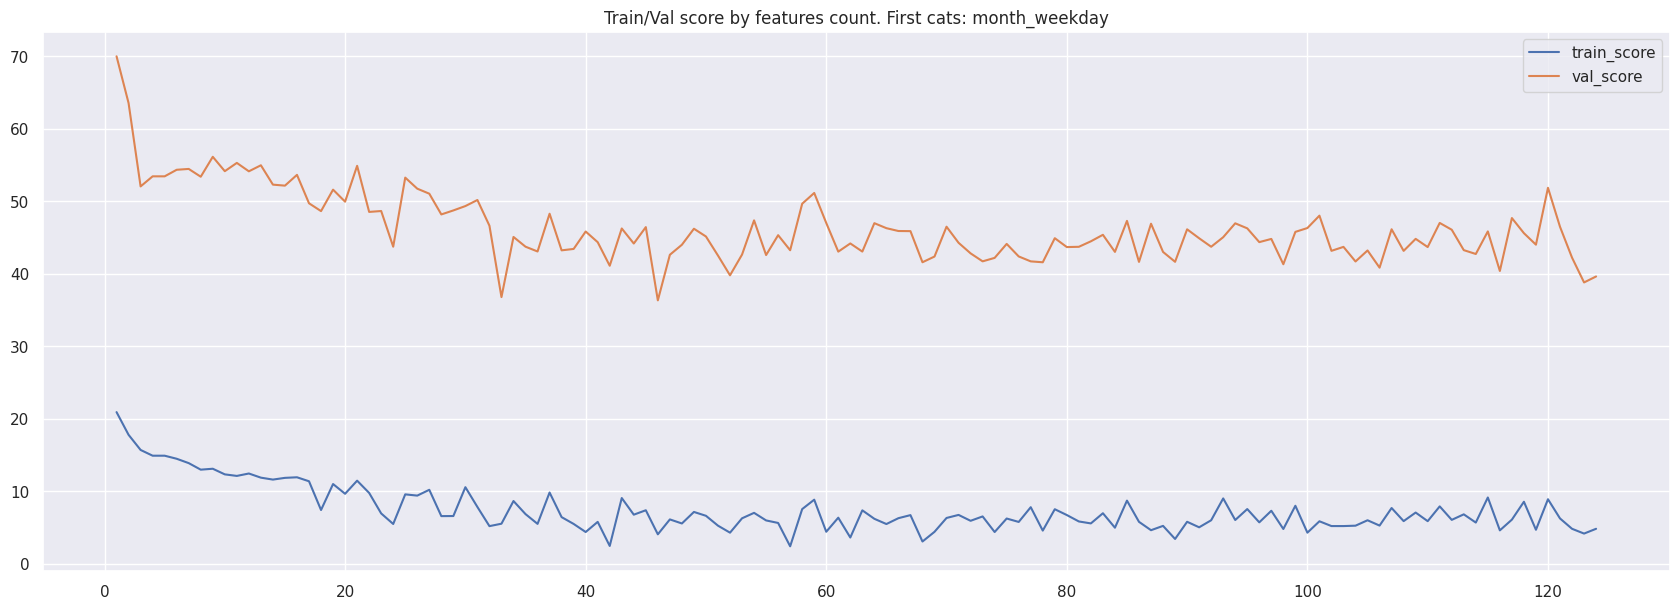

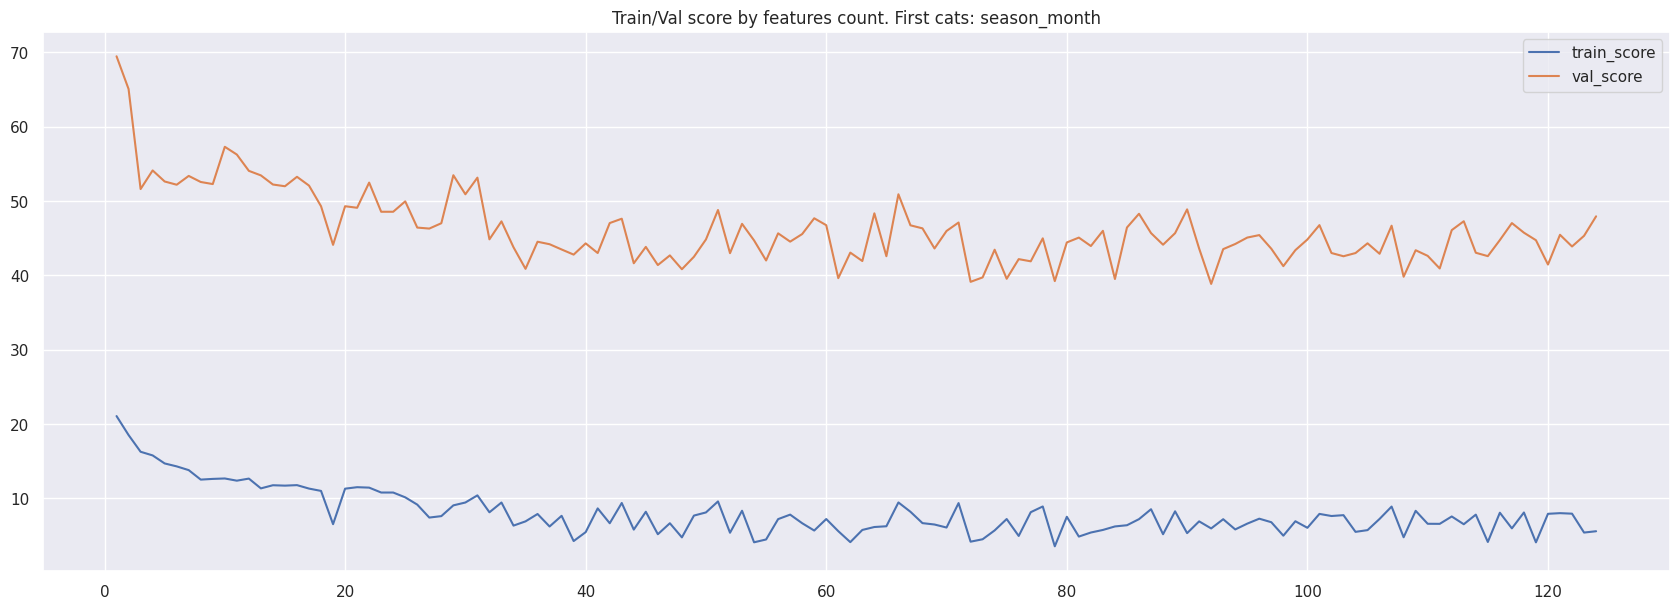

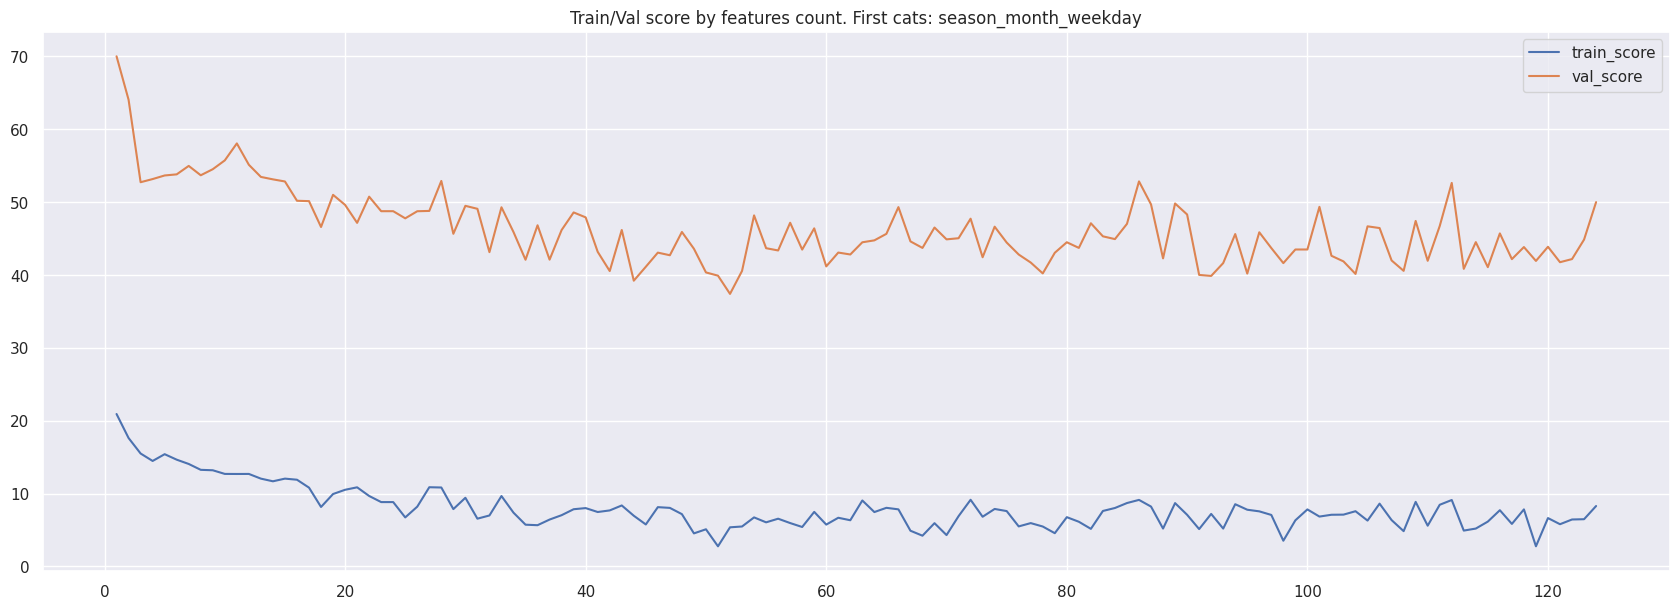

In [91]:
# best_params = {'n_jobs': -1, 'verbosity': -1, 'objective': 'regression', 'metric': 'rmse', 'boosting_type': 'gbdt', 'extra_trees': True, 'n_estimators': 1600, 'num_leaves': 145, 'learning_rate': 0.09686633344736045, 'subsample': 0.9783886230574863, 'subsample_freq': 3, 'subsample_for_bin': 210165, 'min_child_samples': 36, 'reg_alpha': 0.6996611491876404, 'reg_lambda': 0.6668213755991776, 'max_depth': 5, 'max_bin': 339}

score_and_plot_by_feature_count(o_helper, len_features=min(best_features_count, 150), best_params=best_params, categories=categories)

In [61]:
best_categories = ['season', 'month']
best_features_count = 73

score_train, score_val = run_model_by_feature_count(o_helper, best_params, best_categories=best_categories, best_features_count=best_features_count)
score_train, score_val

(4.502194741012753, 39.73344399253436)

In [72]:
best_params = {'n_jobs': -1, 'verbosity': -1, 'objective': 'regression', 'metric': 'rmse', 'boosting_type': 'gbdt', 'extra_trees': False, 'n_estimators': 2100, 'num_leaves': 97, 'learning_rate': 0.11890042003021366, 'subsample': 0.4318782580934736, 'subsample_freq': 0, 'subsample_for_bin': 193295, 'min_child_samples': 14, 'reg_alpha': 0.394194026403052, 'reg_lambda': 0.708405421324422, 'max_depth': 3, 'max_bin': 206}
best_categories = ['month', 'weekday']
best_features_count = 73

o_helper, _, _, _, _ = init_optuna_helper(df_joint, pol_id, default_category=best_categories, categories=[],
             use_aqi_cols=use_aqi_cols, use_c_mean_cols=use_c_mean_cols, use_lag_cols=use_lag_cols, use_gen_lags_cols=use_gen_lags_cols,
                                          use_weather_cols=use_weather_cols)

score_train, score_val = run_model_by_feature_count(o_helper, best_params, best_categories=best_categories, best_features_count=best_features_count)
score_train, score_val

(4.096338645025627, 33.11449808343723)

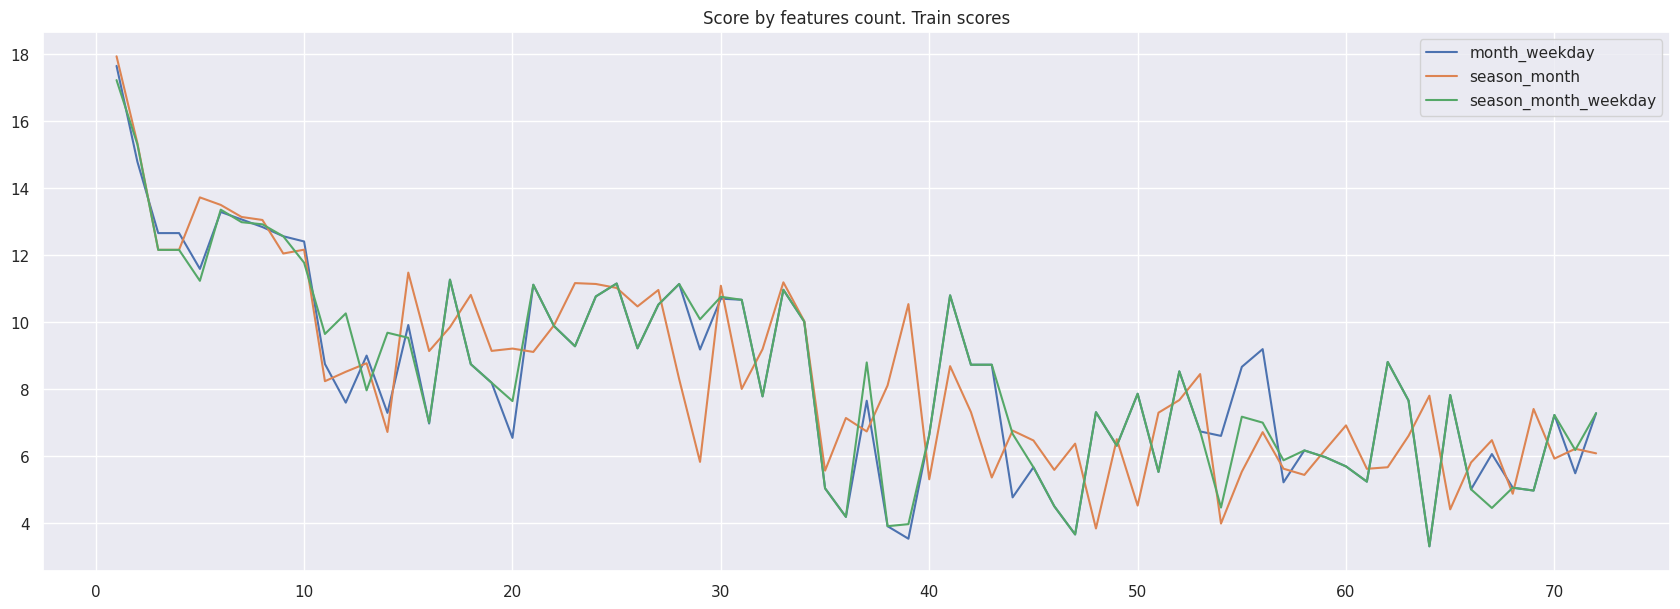

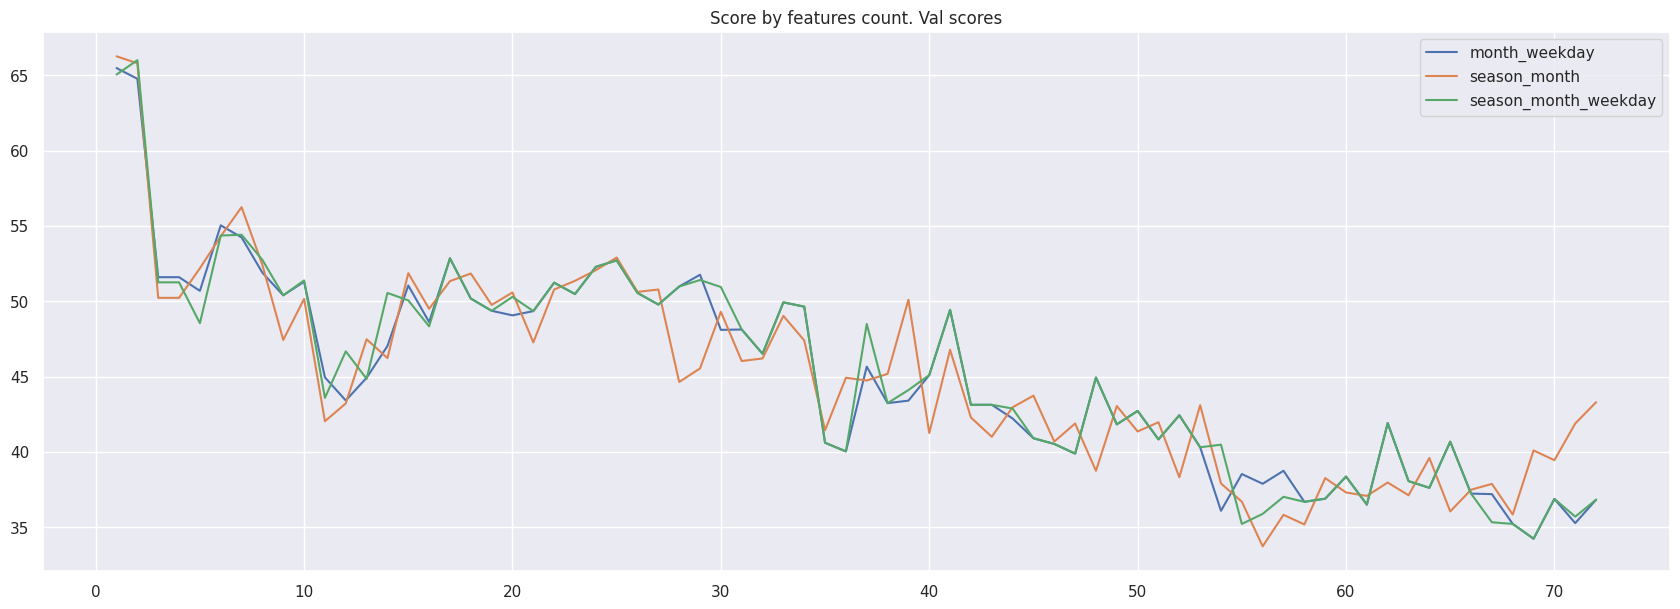

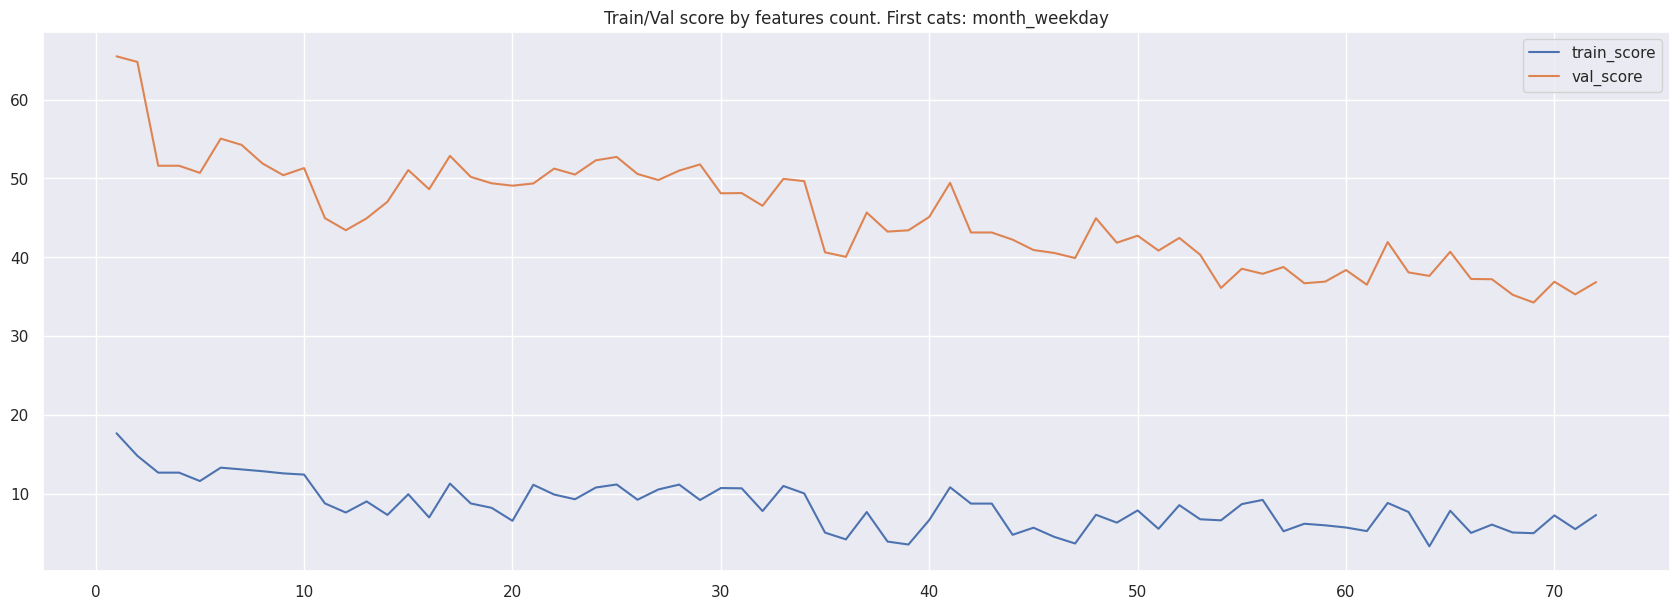

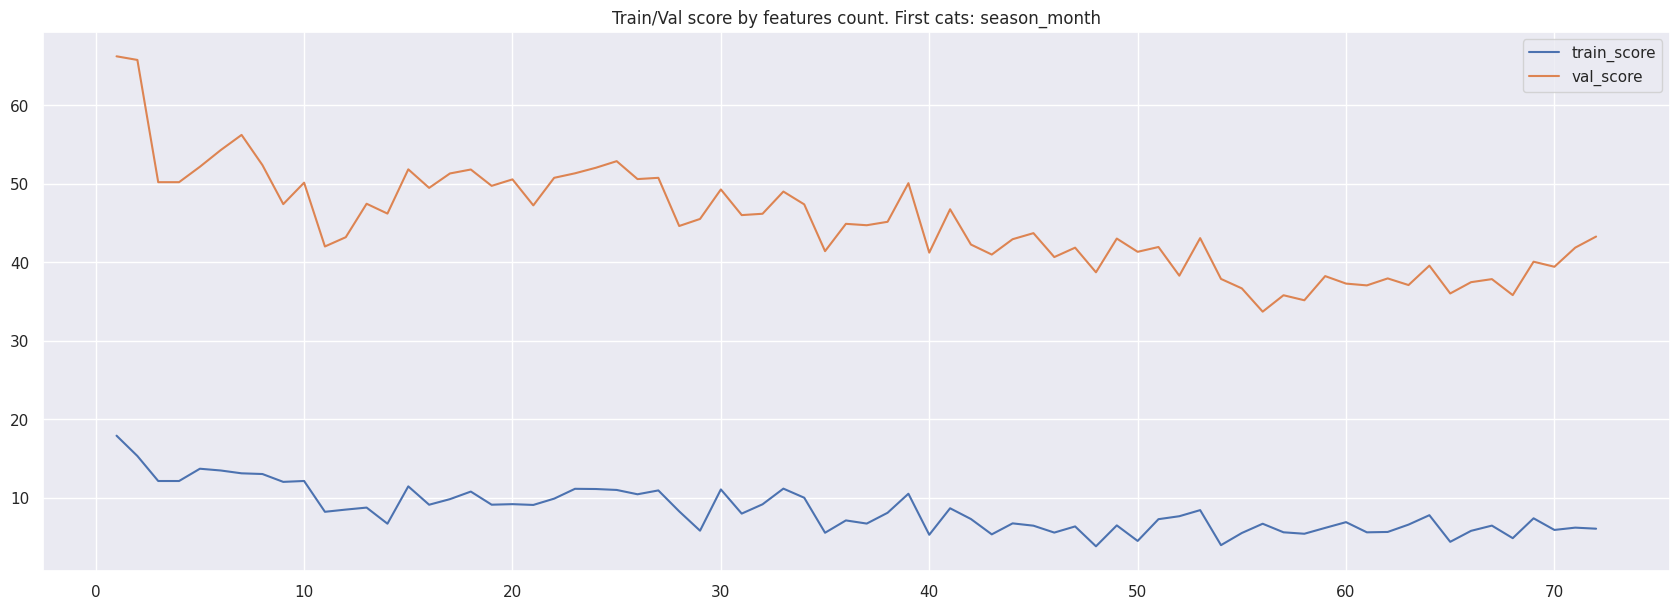

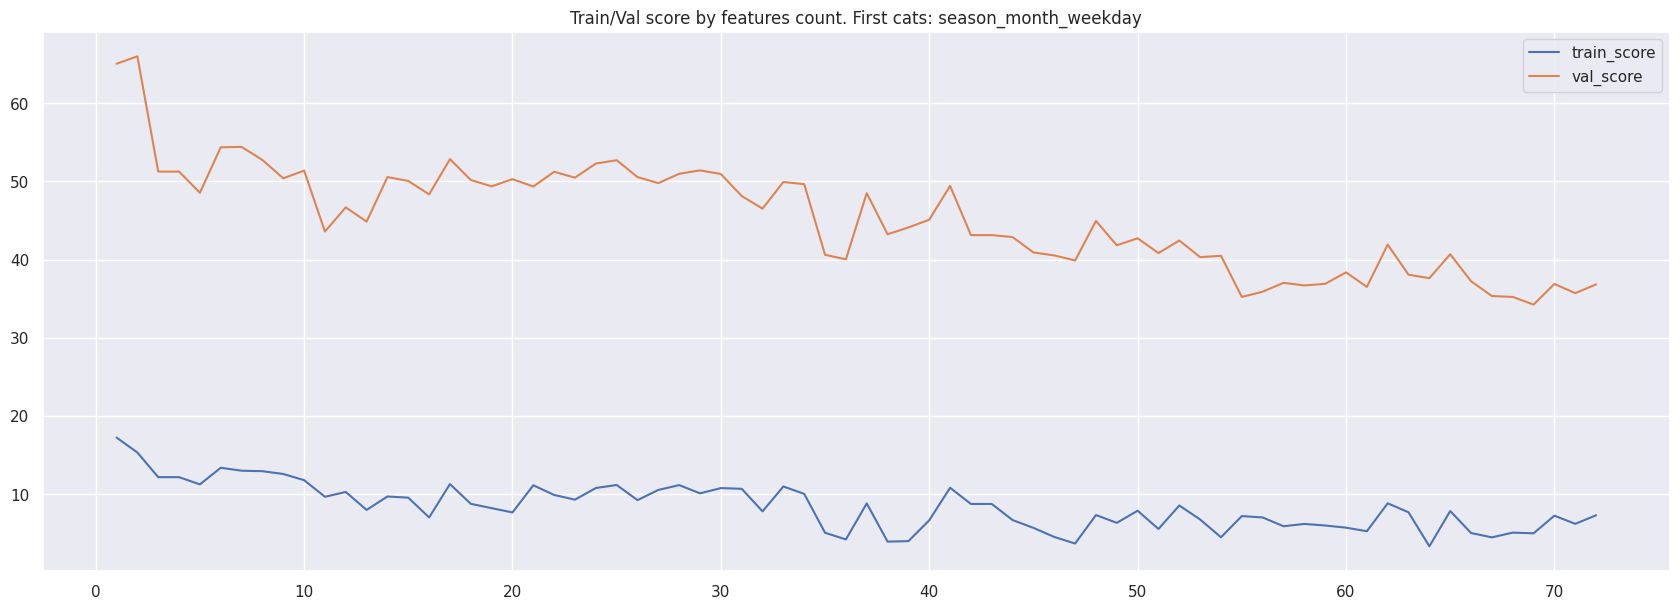

In [66]:
score_and_plot_by_feature_count(o_helper, len_features=min(best_features_count, 150), best_params=best_params, categories=categories)

In [73]:
save_score_and_params(target='AQI', pol_id=pol_id, use_weather_cols=use_weather_cols, use_aqi_cols=use_aqi_cols, use_c_mean_cols=use_c_mean_cols,
                      use_lag_cols=use_lag_cols, use_gen_lags_cols=use_gen_lags_cols, best_params=best_params, best_categories=best_categories,
                      best_features_count=best_features_count, score_train=score_train, score_val=score_val)

### PM2.5 - AQI gen lags

In [74]:
pol_id = 6001
categories=[['month', 'weekday'], ['season', 'month'], ['season', 'month', 'weekday']]
default_category=['month', 'weekday']
use_aqi_cols = False
use_c_mean_cols=True
use_lag_cols = False
use_gen_lags_cols =True
use_weather_cols = False

run_params_search n_trials=100, search_category=True, best_features_only=True, with_pruner=True


  0%|          | 0/100 [00:00<?, ?it/s]

Trial 2 finished with best value: 43.24161356139567 and parameters: {'n_jobs': -1, 'verbosity': -1, 'objective': 'regression', 'metric': 'rmse', 'boosting_type': 'gbdt', 'extra_trees': False, 'n_estimators': 1700, 'num_leaves': 22, 'learning_rate': 0.10593410179641563, 'subsample': 0.35197482426511373, 'subsample_freq': 9, 'subsample_for_bin': 182517, 'min_child_samples': 467, 'reg_alpha': 0.09676308902565711, 'reg_lambda': 0.982528872986122, 'max_depth': 9, 'max_bin': 125, 'categorical_features': ['season', 'month']}. 
Trial 3 finished with best value: 33.15131085982554 and parameters: {'n_jobs': -1, 'verbosity': -1, 'objective': 'regression', 'metric': 'rmse', 'boosting_type': 'gbdt', 'extra_trees': False, 'n_estimators': 2400, 'num_leaves': 137, 'learning_rate': 0.09810190444767644, 'subsample': 0.6317452736130315, 'subsample_freq': 8, 'subsample_for_bin': 365019, 'min_child_samples': 508, 'reg_alpha': 0.349379305365927, 'reg_lambda': 0.12388551465051567, 'max_depth': 3, 'max_bin': 

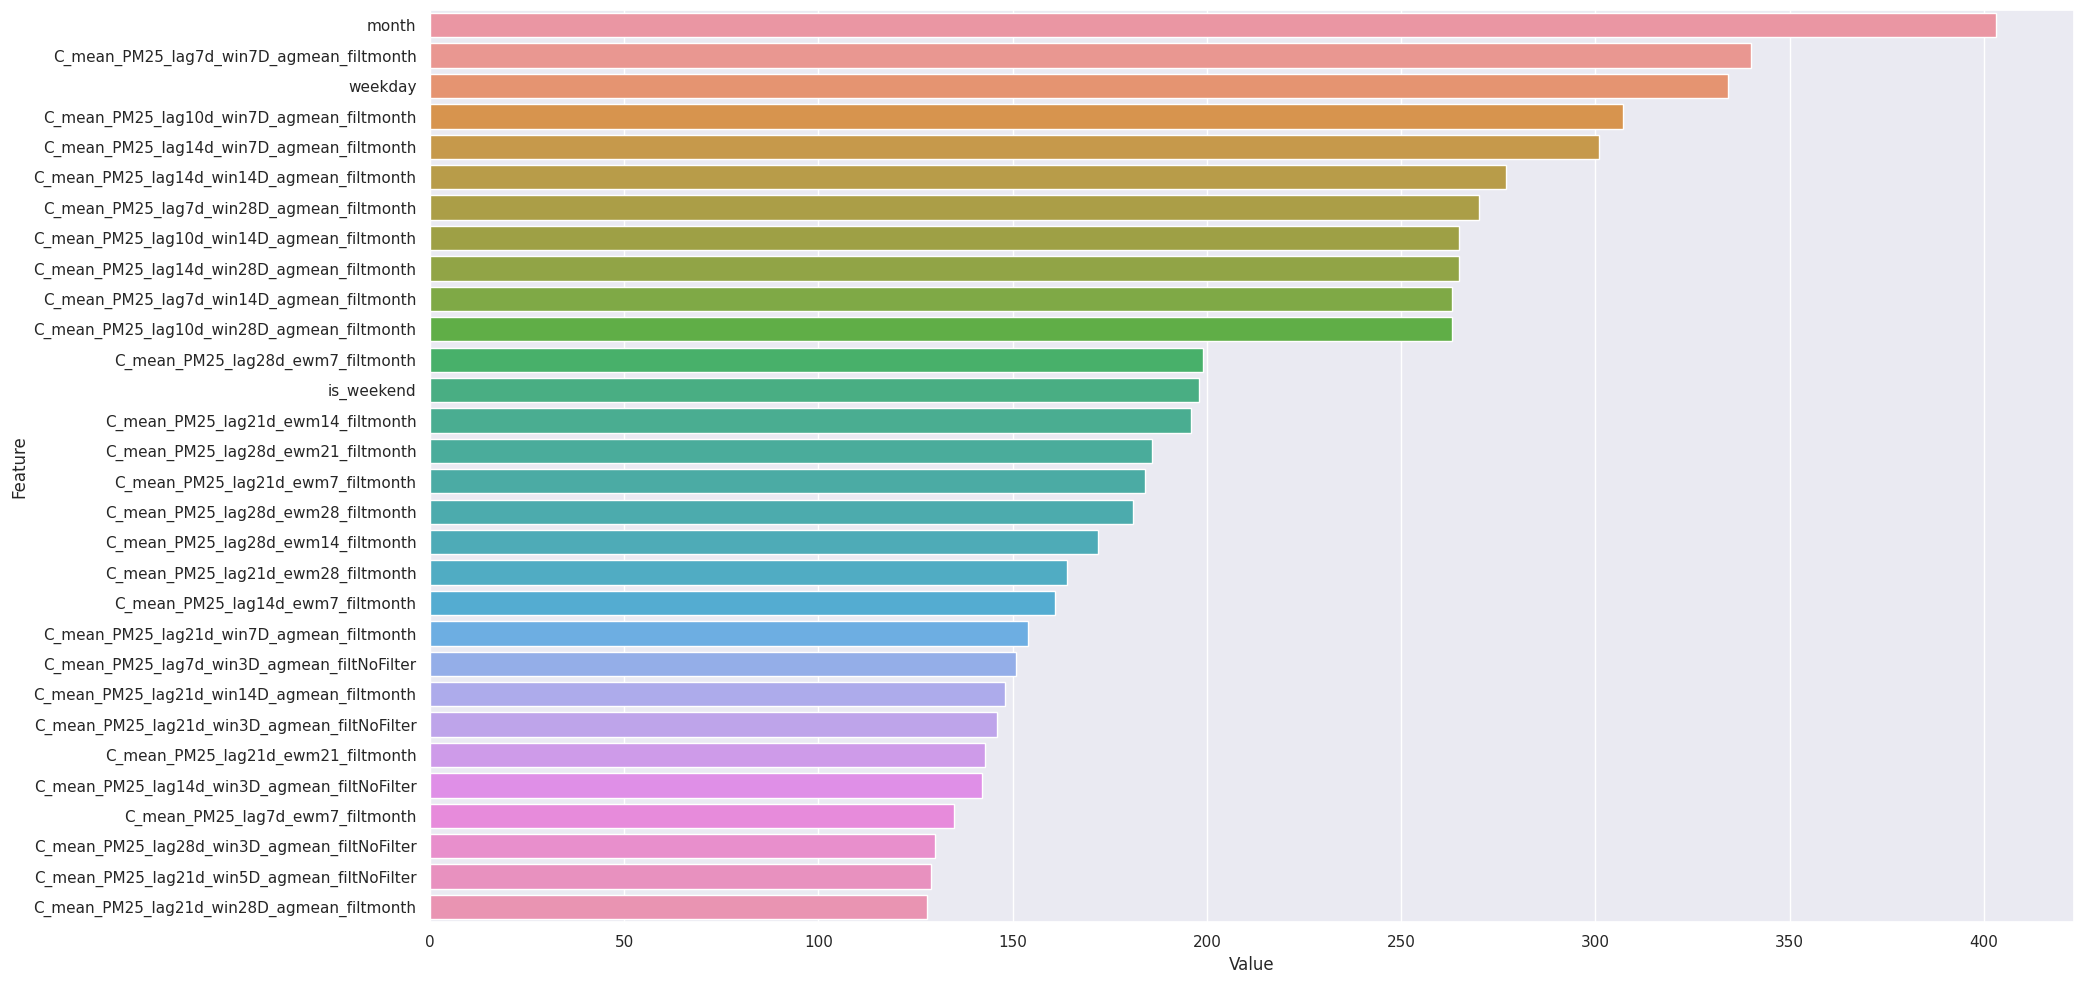

(3.146477648548509, 56.73801106956682)

In [75]:
o_helper, score_train, score_val, best_params, best_categories, best_features_count, feat_imp_df = \
    run_test(df_joint, pol_id, default_category=default_category, categories=categories,
             use_aqi_cols=use_aqi_cols, use_c_mean_cols=use_c_mean_cols, use_lag_cols=use_lag_cols, use_gen_lags_cols=use_gen_lags_cols, use_weather_cols=use_weather_cols)
score_train, score_val

In [ ]:
#score_and_plot_by_feature_count(o_helper, len_features=min(best_features_count, 150), best_params=best_params, categories=categories)

In [76]:
best_categories = ['month', 'weekday']
best_features_count = 70

score_train, score_val = run_model_by_feature_count(o_helper, best_params, best_categories=best_categories, best_features_count=best_features_count)
score_train, score_val

(6.1046403179356545, 56.35866633346242)

In [77]:
save_score_and_params(target='AQI', pol_id=pol_id, use_weather_cols=use_weather_cols, use_aqi_cols=use_aqi_cols, use_c_mean_cols=use_c_mean_cols,
                      use_lag_cols=use_lag_cols, use_gen_lags_cols=use_gen_lags_cols, best_params=best_params, best_categories=best_categories,
                      best_features_count=best_features_count, score_train=score_train, score_val=score_val)

### PM2.5 - AQI lags

In [78]:
pol_id = 6001
categories=[['month', 'weekday'], ['season', 'month'], ['season', 'month', 'weekday']]
default_category=['month', 'weekday']
use_aqi_cols = False
use_c_mean_cols=True
use_lag_cols = True
use_gen_lags_cols = False
use_weather_cols = False

run_params_search n_trials=100, search_category=True, best_features_only=True, with_pruner=True


  0%|          | 0/100 [00:00<?, ?it/s]

Trial 5 finished with best value: 47.65738808816404 and parameters: {'n_jobs': -1, 'verbosity': -1, 'objective': 'regression', 'metric': 'rmse', 'boosting_type': 'gbdt', 'extra_trees': False, 'n_estimators': 2100, 'num_leaves': 123, 'learning_rate': 0.11690586150765034, 'subsample': 0.05833966549122971, 'subsample_freq': 3, 'subsample_for_bin': 156130, 'min_child_samples': 380, 'reg_alpha': 0.7661800043956998, 'reg_lambda': 0.8184762004474069, 'max_depth': 7, 'max_bin': 139, 'categorical_features': ['season', 'month']}. 
Trial 1 finished with best value: 35.418889869994594 and parameters: {'n_jobs': -1, 'verbosity': -1, 'objective': 'regression', 'metric': 'rmse', 'boosting_type': 'gbdt', 'extra_trees': True, 'n_estimators': 1400, 'num_leaves': 24, 'learning_rate': 0.09008607406287047, 'subsample': 0.6007046931682812, 'subsample_freq': 7, 'subsample_for_bin': 395236, 'min_child_samples': 504, 'reg_alpha': 0.8543201899894292, 'reg_lambda': 0.40292266234288965, 'max_depth': 5, 'max_bin':

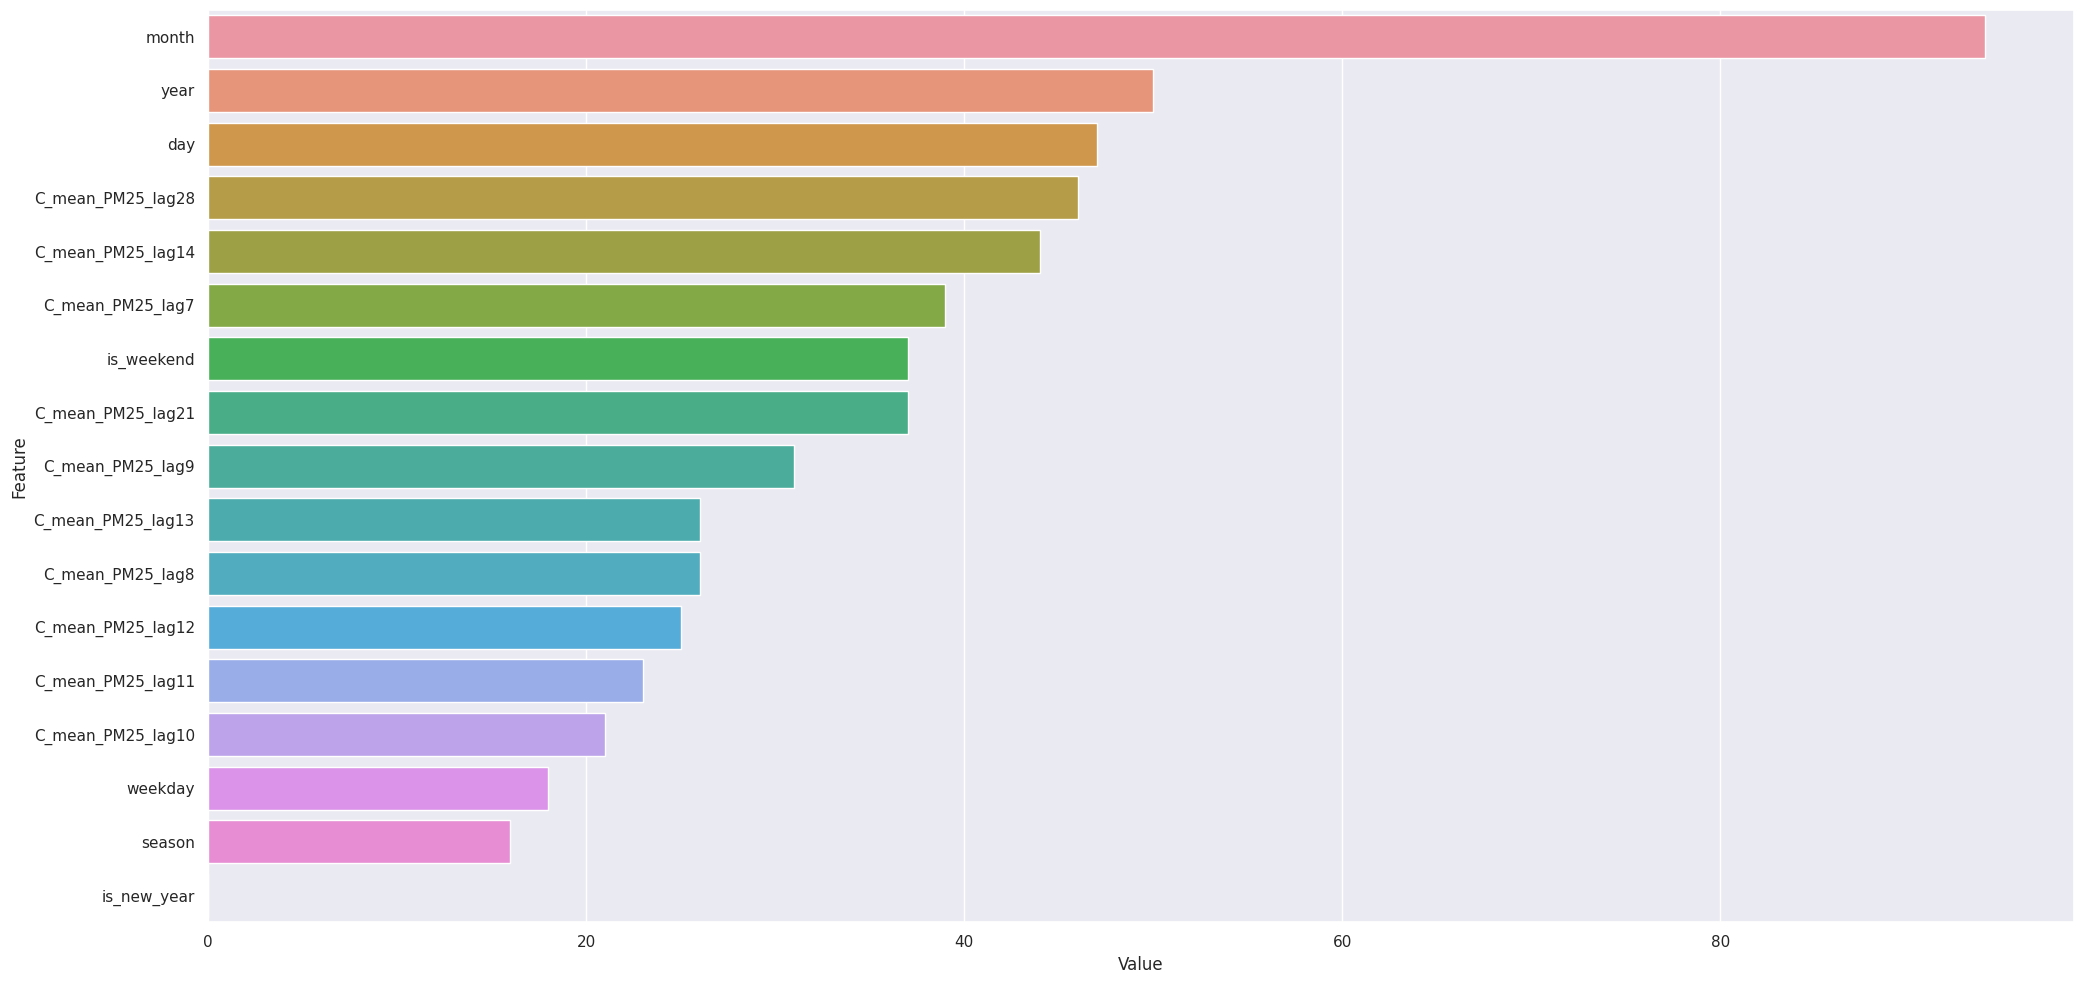

(17.550596821552734, 79.37578102566341)

In [80]:
o_helper, score_train, score_val, best_params, best_categories, best_features_count, feat_imp_df = \
    run_test(df_joint, pol_id, default_category=default_category, categories=categories,
             use_aqi_cols=use_aqi_cols, use_c_mean_cols=use_c_mean_cols, use_lag_cols=use_lag_cols, use_gen_lags_cols=use_gen_lags_cols, use_weather_cols=use_weather_cols)
score_train, score_val

In [ ]:
#score_and_plot_by_feature_count(o_helper, len_features=min(best_features_count, 150), best_params=best_params, categories=categories)

In [82]:
best_categories = ['season', 'month', 'weekday']
best_features_count = 70

score_train, score_val = run_model_by_feature_count(o_helper, best_params, best_categories=best_categories, best_features_count=best_features_count)
score_train, score_val

(17.517325411600407, 78.71140966591524)

In [83]:
save_score_and_params(target='AQI', pol_id=pol_id, use_weather_cols=use_weather_cols, use_aqi_cols=use_aqi_cols, use_c_mean_cols=use_c_mean_cols,
                      use_lag_cols=use_lag_cols, use_gen_lags_cols=use_gen_lags_cols, best_params=best_params, best_categories=best_categories,
                      best_features_count=best_features_count, score_train=score_train, score_val=score_val)

# Forecasts comparison

In [13]:
df_score = pd.read_csv(CSV_SCORE_FILE)
df_score.sort_values(by='val_score', inplace=True)
display(df_score)

,Unnamed: 0,train_score,val_score,target,pol_id,weather_YN,AQI_lags_YN,C_lags_YN,simple_lags_YN,gen_lags_YN,params,categories,top_feat_count
3,4,4.096339,33.114498,AQI,6001,True,False,True,False,True,"{'n_jobs': -1, 'verbosity': -1, 'objective': '...","['month', 'weekday']",73
1,2,4.741128,37.097579,AQI,6001,True,False,True,True,True,"{'n_jobs': -1, 'verbosity': -1, 'objective': '...","['month', 'weekday']",70
0,1,8.559515,46.979339,AQI,6001,True,False,True,True,False,"{'n_jobs': -1, 'verbosity': -1, 'objective': '...","['month', 'weekday']",70
4,5,6.104640,56.358666,AQI,6001,False,False,True,False,True,"{'n_jobs': -1, 'verbosity': -1, 'objective': '...","['month', 'weekday']",70
2,3,11.568749,66.333929,AQI,6001,False,False,True,True,True,"{'n_jobs': -1, 'verbosity': -1, 'objective': '...","['season', 'month', 'weekday']",70
5,6,17.517325,78.711410,AQI,6001,False,False,True,True,False,"{'n_jobs': -1, 'verbosity': -1, 'objective': '...","['season', 'month', 'weekday']",70


In [6]:
_, y_val = ts_splitter.split_x_y_for_period(df=df_joint, index_cols='DatetimeEnd', y_value_col='AQI',                                                           dt_start=VAL_DATE_FROM, dt_end=VAL_DATE_TO)

In [7]:
def get_prediction(df, pol_id, use_weather_cols, use_aqi_cols, use_c_mean_cols, use_lag_cols, use_gen_lags_cols, best_params, best_categories, best_feat_count):
    o_helper, _, _, x_vl, _ = lgbm_fl.init_optuna(
        df=df, pol_id=pol_id, prediction_value_type=lgbm_fl.PredictionValueType.AQI,
        use_aqi_cols=use_aqi_cols, use_c_mean_cols=use_c_mean_cols,
        use_lag_cols=use_lag_cols, use_gen_lags_cols=use_gen_lags_cols, use_weather_cols=use_weather_cols,
        train_start_dt=TRAIN_DATE_FROM, train_end_dt=TRAIN_DATE_TO, test_start_dt=VAL_DATE_FROM, test_end_dt=VAL_DATE_TO,
        default_params=best_params, default_category=best_categories, default_top_features_count=best_feat_count)

    score_train, score_val, _ = o_helper.run_model_and_eval(best_features_only=True, set_as_best_model=True)
    y_vl_pred = [int(round(x, 0)) for x in o_helper.predict_by_best_model(x_vl)]
    return score_train, score_val, y_vl_pred

Weather_GenLags: train score: 4.096338645025626, val score: 33.11449808343723
Weather_SimpleLags_GenLags: train score: 4.741127620346672, val score: 37.0975794319391
Weather_SimpleLags: train score: 8.55951491370446, val score: 46.97933900468251
GenLags: train score: 6.1046403179356545, val score: 56.358666333462416
SimpleLags_GenLags: train score: 12.124822284695902, val score: 64.47869336470109
SimpleLags: train score: 17.391011704100737, val score: 78.70410345887969


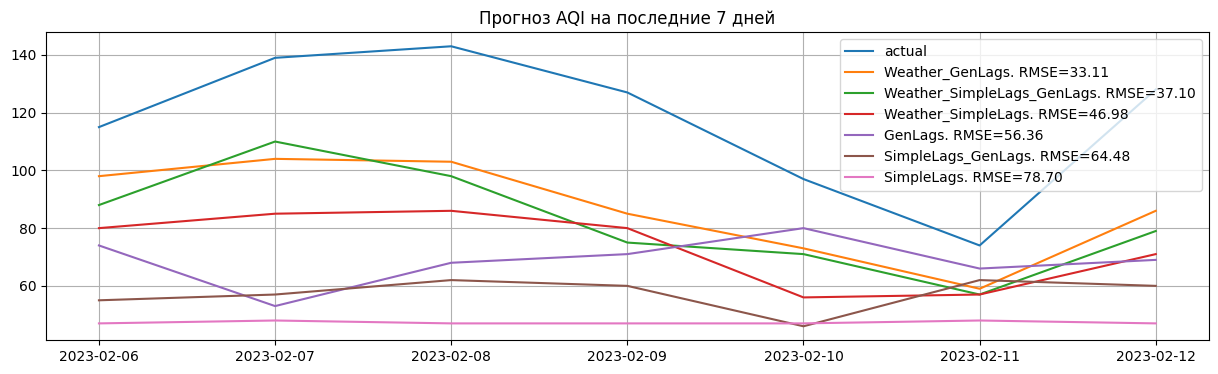

In [14]:
plt.figure(figsize=(15, 4))
plt.title(f"Прогноз AQI на последние 7 дней")
plt.plot(y_val, label="actual")

for index, row in df_score.iterrows():
    str_type = ''
    if row['weather_YN']:
            str_type = 'Weather'
    if row['simple_lags_YN']:
        if str_type != '':
            str_type = str_type + '_'
        str_type = str_type + 'SimpleLags'
    if row['gen_lags_YN']:
        if str_type != '':
            str_type = str_type + '_'
        str_type = str_type + 'GenLags'

    best_pm25_params = {'n_jobs': -1, 'verbosity': -1, 'objective': 'regression', 'metric': 'rmse', 'boosting_type': 'gbdt', 'extra_trees': False, 'n_estimators': 2100, 'num_leaves': 97, 'learning_rate': 0.11890042003021366, 'subsample': 0.4318782580934736, 'subsample_freq': 0, 'subsample_for_bin': 193295, 'min_child_samples': 14, 'reg_alpha': 0.394194026403052, 'reg_lambda': 0.708405421324422, 'max_depth': 3, 'max_bin': 206}
    best_pm25_categories = ['month', 'weekday']
    best_pm25_features_count = 70

    score_train, score_val, y_pred = get_prediction(df_joint, row['pol_id'], row['weather_YN'], row['AQI_lags_YN'], row['C_lags_YN'], row['simple_lags_YN'], row['gen_lags_YN'], eval(row['params']), eval(row['categories']), row['top_feat_count'])
    print(f'{str_type}: train score: {score_train}, val score: {score_val}')
    plt.plot(y_val.index, y_pred, label=str_type + ". RMSE=%.2f" % score_val)


plt.legend()
plt.grid(True)
plt.show()